<a href="https://colab.research.google.com/github/Dyakonov/Colab/blob/main/dj_CLUSTERexperiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Эксперименты с кластеризацией эмбедингов

Попытка сделать общий пайплайн

* UMAP https://umap-learn.readthedocs.io/
* DBSACAN https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html



* скачиваем данные (CLINC - 151 класс)
* берём какую-нибудь модель - из неё представления
* кластеризация в исходном пространстве представлений
* кластеризация в UMAP-пространстве
* перебор параметров


### выводы

* В исходном пространстве всё совсем плохо...
* Для CLINC+UMAP В UMAP лучше использовать cos-метрику - и меньше зависимость от параметров
* В DBSCAN оптимальный eps разный для разных метрик (эвклидова и косинусная)
* SVD/PCA хуже UMAP
* Стандартизация чуть ухудшает качество

In [1]:
# установка необходимых библиотек
!pip install transformers
!pip install datasets
!pip install umap-learn
!pip install -U sentence-transformers
#!pip install fasttsne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=85d82c23407e1a601e2cdfe3036e4cb88a62772107acfa6413f929ea1b81778f
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentenc

## Определение функций и импотр библиотек

In [2]:
# импорт библиотек

from time import time
from tqdm.autonotebook import tqdm
import numpy as np
import torch

from sentence_transformers import SentenceTransformer
from datasets import load_dataset

import umap

from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics  import fowlkes_mallows_score
from sklearn.metrics  import adjusted_mutual_info_score
from sklearn.metrics  import adjusted_rand_score
from sklearn.metrics.cluster import v_measure_score

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

<ipython-input-2-818cb78f5abd>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
%pylab inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
# import warnings
# warnings.filterwarnings("ignore")
# pd.set_option('display.max_columns', None)
import matplotlib as mpl
plt.rc('font', size=14)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +
<ipython-input-3-b9024b5e3293>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def make_coding_model(model='sbert', mode='paraphrase-MiniLM-L6-v2'):
  """
  кодирующая модель - для получения представлений
  """
  if model == 'sbert':
    print (f'модель: {model}, модификация: {mode}')
    model = SentenceTransformer(mode)
    return model.encode
  print ('Неизвестная модель')
  return NaN


def make_dataset(coding_model, name='clinc', mode='train'):
  """
  датасет для экспериментов
  """
  print (f'датасет {name}, часть {mode}')
  if name == 'clinc':
    data = load_dataset("clinc_oos", "plus")
    m = data["train"].num_rows # число объектов в датасете
    print (f'число объектов = {m}')

    n = len(coding_model('example'))
    print (f'число признаков = {n}')

    X = np.zeros([m, n])
    y = np.zeros(m)

    texts = data[mode]['text']
    labels = data[mode]['intent']

    for j in tqdm(range(m)):
      X[j, :] =  coding_model(texts[j]) #model.encode(texts[j])
      y[j] = labels[j]
    return X, y, data

  print("Неизвестный запрос")
  return NaN, NaN, NaN

In [6]:
coding_model = make_coding_model(model='sbert', mode='sentence-t5-base') # 'paraphrase-MiniLM-L6-v2'
X, y, data = make_dataset(coding_model, name='clinc', mode='train')

модель: sbert, модификация: sentence-t5-base


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

convert.ipynb:   0%|          | 0.00/74.6k [00:00<?, ?B/s]

convert_to_fp16.py:   0%|          | 0.00/198 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/219M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

датасет clinc, часть train


Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

число объектов = 15250
число признаков = 768


  0%|          | 0/15250 [00:00<?, ?it/s]

In [8]:
np.save('/content/drive/My Drive/clusterdata/X_clinc', X)
np.save('/content/drive/My Drive/clusterdata/y_clinc', y)

# Сначала просто кластеризация

In [14]:
n_neighbors = 32
min_dist = 0.001
n_components = 2
l = len(np.unique(y))
print (f'число кластеров = {l}')

t0 = time.time()

reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric='euclidean') # cosine
embedding = reducer.fit_transform(X)
clustering_emb = KMeans(n_clusters=l).fit(embedding)
a = clustering_emb.labels_


V = v_measure_score(y, a)
H =homogeneity_score(y, a)
C = completeness_score(y, a)
NC = len(np.unique(a))
FM = fowlkes_mallows_score(y, a)
MI = adjusted_mutual_info_score(y, a)
RS = adjusted_rand_score(y, a)
T = time.time() - t0

print (f"n_neighbors={n_neighbors}, min_dist={min_dist}, n_components={n_components}, V={np.round(V, 4)}, H={np.round(H, 4)}, C={np.round(C, 4)}, NC={np.round(NC, 4)}, FM={np.round(FM, 4)}, MI={np.round(MI, 4)}, RS={np.round(RS, 4)}, T={np.round(T, 4)}")

число кластеров = 151


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


n_neighbors=32, min_dist=0.001, n_components=2, V=0.9342, H=0.9299, C=0.9386, NC=151, FM=0.8008, MI=0.922, RS=0.7987, T=65.684


In [106]:
# umap.UMAP(n_neighbors=64, min_dist=0.0001, n_components=4, metric='cosine')

n_neighbors = 64
min_dist = 0.0001
n_components = 4
l = len(np.unique(y))
print (f'число кластеров = {l}')

t0 = time.time()

reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric='cosine') # cosine
embedding = reducer.fit_transform(X)
#clustering_emb = KMeans(n_clusters=l).fit(embedding)
clustering_emb = DBSCAN(eps=0.1, min_samples=8, metric='euclidean').fit(embedding)
a = clustering_emb.labels_


V = v_measure_score(y, a)
H =homogeneity_score(y, a)
C = completeness_score(y, a)
NC = len(np.unique(a))
FM = fowlkes_mallows_score(y, a)
MI = adjusted_mutual_info_score(y, a)
RS = adjusted_rand_score(y, a)
T = time.time() - t0

print (f"n_neighbors={n_neighbors}, min_dist={min_dist}, n_components={n_components}, V={np.round(V, 4)}, H={np.round(H, 4)}, C={np.round(C, 4)}, NC={np.round(NC, 4)}, FM={np.round(FM, 4)}, MI={np.round(MI, 4)}, RS={np.round(RS, 4)}, T={np.round(T, 4)}")
# n_neighbors=64, min_dist=0.0001, n_components=4, V=0.9342, H=0.9277, C=0.9407, NC=151, FM=0.7944, MI=0.9221, RS=0.7915, T=39.916
# n_neighbors=64, min_dist=0.0001, n_components=4, V=0.9345, H=0.9298, C=0.9393, NC=151, FM=0.8012, MI=0.9224, RS=0.799, T=50.8225
# 153 кластера V=0.922, H=0.9083, C=0.9361, NC=153, FM=0.717, MI=0.9081, RS=0.7067, T=44.2682

число кластеров = 151
n_neighbors=64, min_dist=0.0001, n_components=4, V=0.922, H=0.9083, C=0.9361, NC=153, FM=0.717, MI=0.9081, RS=0.7067, T=44.2682


In [108]:
len(np.unique(a))

153

In [34]:
%pylab inline
plt.style.use('seaborn-dark')
#import warnings
#warnings.filterwarnings("ignore")
#pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('font', size=14)

# import seaborn as sns
%matplotlib inline

%config Completer.use_jedi = False

Populating the interactive namespace from numpy and matplotlib


<ipython-input-34-60700079bde2>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


In [115]:
a[a<0] = 99999

In [119]:
np.mean(a == 99999)

0.02662295081967213

Text(0, 0.5, 'component 2')

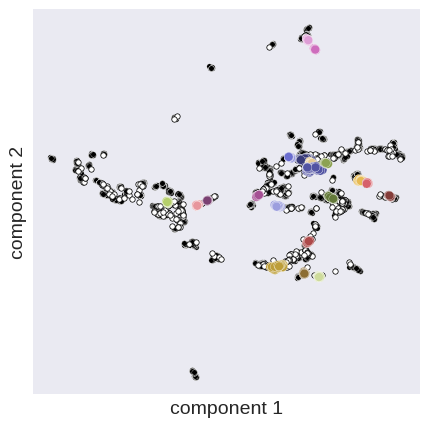

In [118]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
k = 20
plt.scatter(embedding[a >= k, 0],
            embedding[a >= k, 1],
            15, 'k', edgecolor='w',
            lw=0.2,)
plt.scatter(embedding[a == 99999, 0],
            embedding[a == 99999, 1],
            15, 'w', edgecolor='k',
            lw=0.5,)
plt.scatter(embedding[a < k, 0],
            embedding[a < k, 1],
            40,
            a[a < k],
            lw=0.2,
            edgecolor='w',
            cmap='tab20b')
plt.xticks([])
plt.yticks([])
plt.xlabel('component 1', fontsize=14)
plt.ylabel('component 2', fontsize=14)

Text(0, 0.5, 'component 2')

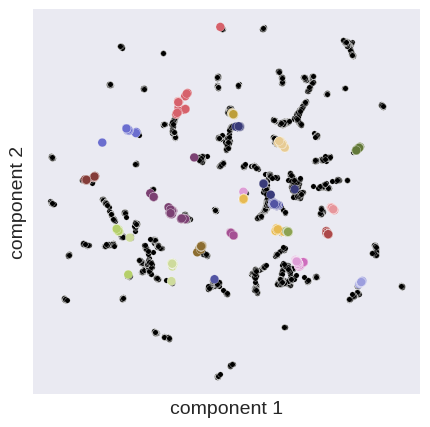

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
k = 20
plt.scatter(embedding[y >= k, 0],
            embedding[y >= k, 1],
            15, 'k', edgecolor='w',
            lw=0.2,)
plt.scatter(embedding[y < k, 0],
            embedding[y < k, 1],
            40,
            y[y < k],
            lw=0.2,
            edgecolor='w',
            cmap='tab20b')
plt.xticks([])
plt.yticks([])
plt.xlabel('component 1', fontsize=14)
plt.ylabel('component 2', fontsize=14)

In [58]:
#data['train']['text'][0]
k = 9
n_clust = 15
for t in range(n_clust):
  print ('------ кластер', t)
  for y_, s in  ((y[i], data['train']['text'][i]) for i in np.nonzero(a==t)[0][:k]):
    print (f"{int(y_)}, {s}")

------ кластер 0
53, remind me to call my mother saturday morning
53, set a reminder to call my mom
53, remind me friday to call my mother
26, can you text elizabeth and tell them i forgot to bring drinks
26, text wenona and tell her we will be there tomorrow
26, text christopher and tell him i will stop by
26, text audrey and tell her i will be there soon
26, text christy and ask her what she wants for dinner
26, can you text christopher and tell them im on my way
------ кластер 1
123, when should i change my car oil
123, do i need to change my oil
123, how often do you have to change your oil
123, how do i know when i have to change my oil
123, when do i need to change my oil
123, when am i due for an oil change
123, how long before i neet to get my oil changed
123, at how many miles am i required to get my oil changed
123, when should my oil get changed
------ кластер 2
61, if i were english how would i say subway
61, i would i say subway if i were english
61, in england how do they

In [112]:
k = 9
n_clust = 15
for t in range(n_clust):
  print ('------ кластер', t)
  for y_, s in  ((y[i], data['train']['text'][i]) for i in np.nonzero(a==t)[0][:k]):
    print (f"{int(y_)}, {s}")

------ кластер 0
61, what expression would i use to say i love you if i were an italian
61, can you tell me how to say 'i do not speak much spanish', in spanish
61, what is the equivalent of, 'life is good' in french
61, tell me how to say, 'it is a beautiful morning' in italian
61, how do i say 'hotel' in finnish
61, please tell me how to ask for a taxi in french
61, can you tell me how i would say, 'more bread please' in french
61, what is the correct way to say 'i am a visitor' in french
61, how would i say, 'i don't know the answer' in spanish
------ кластер 1
61, if i were mongolian, how would i say that i am a tourist
144, please change the name you refer to me by
144, how do i change the name you use to address me
144, is there a way i can change the name you use to address me
144, i need to change my name to something else for you to call me
144, can i have you call me something else
144, i go by brad
144, usually people refer to me as brad
144, i prefer to go by brad
------ кл

## k-means с нужным числом кластеров

Перебираем параметры UMAP

In [60]:
# Эксперименты - пробуем разные параметры UMAP

# параметры
parameters_n_neighbors = [8, 16, 32, 64, 128] #
parameters_min_dist = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1] #
parameters_n_components = [2, 4, 8, 16]

# инициализация
V = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
H = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
C = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
NC =  np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)), dtype=int)
FM = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
MI = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
RS = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
T = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))

l = len(np.unique(y))
print (f'число кластеров = {l}')

# перебор
for i, n_neighbors in enumerate(parameters_n_neighbors): # tqdm
  for j, min_dist in enumerate(parameters_min_dist):
    for k, n_components in enumerate(parameters_n_components):

      t0 = time.time()
      reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric='euclidean') # cosine
      embedding = reducer.fit_transform(X)
      clustering_emb = KMeans(n_clusters=l).fit(embedding)
      a = clustering_emb.labels_

      V[i, j, k] = v_measure_score(y, a)
      H[i, j, k] =homogeneity_score(y, a)
      C[i, j, k] = completeness_score(y, a)
      NC[i, j, k] = len(np.unique(a))
      FM[i, j, k] = fowlkes_mallows_score(y, a)
      MI[i, j, k] = adjusted_mutual_info_score(y, a)
      RS[i, j, k] = adjusted_rand_score(y, a)
      T[i, j, k] = time.time() - t0

      print (f"i={i}, j={j}, k={k} n_neighbors={n_neighbors}, min_dist={min_dist}, n_components={n_components}, V={np.round(V[i, j, k], 4)}, H={np.round(H[i, j, k], 4)}, C={np.round(C[i, j, k], 4)}, NC={np.round(NC[i, j, k], 4)}, FM={np.round(FM[i, j, k], 4)}, MI={np.round(MI[i, j, k], 4)}, RS={np.round(RS[i, j, k], 4)}, T={np.round(T[i, j, k], 4)}")

число кластеров = 151


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=0, k=0 n_neighbors=8, min_dist=0, n_components=2, V=0.9134, H=0.9054, C=0.9216, NC=151, FM=0.7332, MI=0.8977, RS=0.729, T=30.5177


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=0, k=1 n_neighbors=8, min_dist=0, n_components=4, V=0.9225, H=0.9122, C=0.9331, NC=151, FM=0.7521, MI=0.9086, RS=0.747, T=31.3723


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=0, k=2 n_neighbors=8, min_dist=0, n_components=8, V=0.9256, H=0.9181, C=0.9331, NC=151, FM=0.7665, MI=0.912, RS=0.7628, T=23.664


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=0, k=3 n_neighbors=8, min_dist=0, n_components=16, V=0.9264, H=0.919, C=0.9338, NC=151, FM=0.773, MI=0.913, RS=0.7695, T=21.6558


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=1, k=0 n_neighbors=8, min_dist=1e-05, n_components=2, V=0.9108, H=0.9018, C=0.92, NC=151, FM=0.7229, MI=0.8947, RS=0.7181, T=12.2605


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=1, k=1 n_neighbors=8, min_dist=1e-05, n_components=4, V=0.929, H=0.9223, C=0.9358, NC=151, FM=0.7788, MI=0.916, RS=0.7756, T=14.0979


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=1, k=2 n_neighbors=8, min_dist=1e-05, n_components=8, V=0.9279, H=0.9194, C=0.9365, NC=151, FM=0.7689, MI=0.9148, RS=0.7647, T=17.9097


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=1, k=3 n_neighbors=8, min_dist=1e-05, n_components=16, V=0.9302, H=0.9235, C=0.937, NC=151, FM=0.784, MI=0.9174, RS=0.7809, T=23.5589


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=2, k=0 n_neighbors=8, min_dist=0.0001, n_components=2, V=0.9093, H=0.8996, C=0.9192, NC=151, FM=0.7162, MI=0.8929, RS=0.7109, T=12.8461


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=2, k=1 n_neighbors=8, min_dist=0.0001, n_components=4, V=0.927, H=0.9191, C=0.935, NC=151, FM=0.7707, MI=0.9137, RS=0.7669, T=14.1821


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=2, k=2 n_neighbors=8, min_dist=0.0001, n_components=8, V=0.9233, H=0.9141, C=0.9326, NC=151, FM=0.7513, MI=0.9094, RS=0.7465, T=15.912


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=2, k=3 n_neighbors=8, min_dist=0.0001, n_components=16, V=0.9282, H=0.9216, C=0.9348, NC=151, FM=0.7764, MI=0.915, RS=0.7731, T=23.0314


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=3, k=0 n_neighbors=8, min_dist=0.001, n_components=2, V=0.9093, H=0.8984, C=0.9204, NC=151, FM=0.7141, MI=0.893, RS=0.7083, T=14.7897


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=3, k=1 n_neighbors=8, min_dist=0.001, n_components=4, V=0.927, H=0.918, C=0.9361, NC=151, FM=0.7631, MI=0.9137, RS=0.7587, T=13.8362


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=3, k=2 n_neighbors=8, min_dist=0.001, n_components=8, V=0.9279, H=0.9214, C=0.9345, NC=151, FM=0.7785, MI=0.9147, RS=0.7754, T=16.1114


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=3, k=3 n_neighbors=8, min_dist=0.001, n_components=16, V=0.9279, H=0.9208, C=0.935, NC=151, FM=0.7725, MI=0.9147, RS=0.769, T=23.0338


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=4, k=0 n_neighbors=8, min_dist=0.01, n_components=2, V=0.9111, H=0.9017, C=0.9208, NC=151, FM=0.7227, MI=0.8951, RS=0.7176, T=13.1486


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=4, k=1 n_neighbors=8, min_dist=0.01, n_components=4, V=0.9209, H=0.9116, C=0.9305, NC=151, FM=0.7461, MI=0.9067, RS=0.7414, T=14.4162


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=4, k=2 n_neighbors=8, min_dist=0.01, n_components=8, V=0.9272, H=0.92, C=0.9345, NC=151, FM=0.7719, MI=0.9139, RS=0.7683, T=16.843


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=4, k=3 n_neighbors=8, min_dist=0.01, n_components=16, V=0.9246, H=0.9176, C=0.9317, NC=151, FM=0.7655, MI=0.9108, RS=0.7622, T=22.9379


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=5, k=0 n_neighbors=8, min_dist=0.1, n_components=2, V=0.9151, H=0.9072, C=0.9231, NC=151, FM=0.7389, MI=0.8996, RS=0.7348, T=13.3334


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=5, k=1 n_neighbors=8, min_dist=0.1, n_components=4, V=0.9283, H=0.9206, C=0.9361, NC=151, FM=0.7703, MI=0.9152, RS=0.7665, T=15.3123


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=5, k=2 n_neighbors=8, min_dist=0.1, n_components=8, V=0.9293, H=0.922, C=0.9366, NC=151, FM=0.7751, MI=0.9163, RS=0.7715, T=16.2504


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=0, j=5, k=3 n_neighbors=8, min_dist=0.1, n_components=16, V=0.9269, H=0.9201, C=0.9338, NC=151, FM=0.7685, MI=0.9134, RS=0.7648, T=23.0125


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=0, k=0 n_neighbors=16, min_dist=0, n_components=2, V=0.9319, H=0.9259, C=0.938, NC=151, FM=0.7869, MI=0.9194, RS=0.7841, T=15.9562


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=0, k=1 n_neighbors=16, min_dist=0, n_components=4, V=0.934, H=0.928, C=0.9402, NC=151, FM=0.7932, MI=0.9219, RS=0.7903, T=16.22


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=0, k=2 n_neighbors=16, min_dist=0, n_components=8, V=0.9347, H=0.9288, C=0.9407, NC=151, FM=0.794, MI=0.9226, RS=0.791, T=20.4761


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=0, k=3 n_neighbors=16, min_dist=0, n_components=16, V=0.9357, H=0.9305, C=0.9409, NC=151, FM=0.8024, MI=0.9238, RS=0.8, T=27.1416


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=1, k=0 n_neighbors=16, min_dist=1e-05, n_components=2, V=0.9321, H=0.9242, C=0.9402, NC=151, FM=0.7791, MI=0.9197, RS=0.7751, T=15.3947


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=1, k=1 n_neighbors=16, min_dist=1e-05, n_components=4, V=0.9345, H=0.9292, C=0.9399, NC=151, FM=0.7961, MI=0.9224, RS=0.7936, T=15.9811


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=1, k=2 n_neighbors=16, min_dist=1e-05, n_components=8, V=0.9317, H=0.9242, C=0.9394, NC=151, FM=0.7772, MI=0.9192, RS=0.7733, T=19.5538


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=1, k=3 n_neighbors=16, min_dist=1e-05, n_components=16, V=0.9302, H=0.9237, C=0.9369, NC=151, FM=0.778, MI=0.9174, RS=0.7748, T=27.777


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=2, k=0 n_neighbors=16, min_dist=0.0001, n_components=2, V=0.9314, H=0.9254, C=0.9375, NC=151, FM=0.7862, MI=0.9188, RS=0.7834, T=15.1828


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=2, k=1 n_neighbors=16, min_dist=0.0001, n_components=4, V=0.934, H=0.9285, C=0.9396, NC=151, FM=0.7944, MI=0.9218, RS=0.7917, T=16.6269


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=2, k=2 n_neighbors=16, min_dist=0.0001, n_components=8, V=0.9341, H=0.9288, C=0.9394, NC=151, FM=0.7983, MI=0.9219, RS=0.7959, T=18.8472


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=2, k=3 n_neighbors=16, min_dist=0.0001, n_components=16, V=0.9342, H=0.9285, C=0.9399, NC=151, FM=0.7959, MI=0.922, RS=0.7932, T=26.9129


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=3, k=0 n_neighbors=16, min_dist=0.001, n_components=2, V=0.9318, H=0.9245, C=0.9391, NC=151, FM=0.7826, MI=0.9193, RS=0.7791, T=15.8707


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=3, k=1 n_neighbors=16, min_dist=0.001, n_components=4, V=0.9322, H=0.9267, C=0.9378, NC=151, FM=0.7894, MI=0.9197, RS=0.7868, T=15.8691


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=3, k=2 n_neighbors=16, min_dist=0.001, n_components=8, V=0.9319, H=0.9254, C=0.9384, NC=151, FM=0.7826, MI=0.9194, RS=0.7795, T=19.8396


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=3, k=3 n_neighbors=16, min_dist=0.001, n_components=16, V=0.9332, H=0.9277, C=0.9388, NC=151, FM=0.7909, MI=0.9209, RS=0.7883, T=27.6809


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=4, k=0 n_neighbors=16, min_dist=0.01, n_components=2, V=0.9311, H=0.9228, C=0.9396, NC=151, FM=0.772, MI=0.9186, RS=0.7677, T=15.5652


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=4, k=1 n_neighbors=16, min_dist=0.01, n_components=4, V=0.934, H=0.9283, C=0.9398, NC=151, FM=0.7944, MI=0.9219, RS=0.7917, T=18.7326


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=4, k=2 n_neighbors=16, min_dist=0.01, n_components=8, V=0.9342, H=0.9287, C=0.9397, NC=151, FM=0.7972, MI=0.922, RS=0.7947, T=19.0154


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=4, k=3 n_neighbors=16, min_dist=0.01, n_components=16, V=0.9337, H=0.9275, C=0.94, NC=151, FM=0.7902, MI=0.9215, RS=0.7873, T=28.3254


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=5, k=0 n_neighbors=16, min_dist=0.1, n_components=2, V=0.9316, H=0.9246, C=0.9387, NC=151, FM=0.7828, MI=0.9191, RS=0.7794, T=15.6093


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=5, k=1 n_neighbors=16, min_dist=0.1, n_components=4, V=0.933, H=0.9277, C=0.9382, NC=151, FM=0.7925, MI=0.9205, RS=0.79, T=17.8112


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=5, k=2 n_neighbors=16, min_dist=0.1, n_components=8, V=0.9336, H=0.9272, C=0.9401, NC=151, FM=0.7887, MI=0.9214, RS=0.7856, T=20.0413


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=1, j=5, k=3 n_neighbors=16, min_dist=0.1, n_components=16, V=0.9335, H=0.9276, C=0.9394, NC=151, FM=0.7917, MI=0.9212, RS=0.7889, T=28.0601


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=0, k=0 n_neighbors=32, min_dist=0, n_components=2, V=0.9325, H=0.9271, C=0.938, NC=151, FM=0.7911, MI=0.92, RS=0.7885, T=21.2889


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=0, k=1 n_neighbors=32, min_dist=0, n_components=4, V=0.9336, H=0.9288, C=0.9384, NC=151, FM=0.7969, MI=0.9213, RS=0.7946, T=22.74


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=0, k=2 n_neighbors=32, min_dist=0, n_components=8, V=0.9372, H=0.9323, C=0.9421, NC=151, FM=0.8073, MI=0.9256, RS=0.8049, T=24.9299


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=0, k=3 n_neighbors=32, min_dist=0, n_components=16, V=0.9342, H=0.9287, C=0.9397, NC=151, FM=0.7949, MI=0.922, RS=0.7923, T=34.8202


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=1, k=0 n_neighbors=32, min_dist=1e-05, n_components=2, V=0.9366, H=0.9314, C=0.9419, NC=151, FM=0.8048, MI=0.9249, RS=0.8024, T=20.8443


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=1, k=1 n_neighbors=32, min_dist=1e-05, n_components=4, V=0.9345, H=0.929, C=0.94, NC=151, FM=0.7968, MI=0.9224, RS=0.7943, T=20.9037


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=1, k=2 n_neighbors=32, min_dist=1e-05, n_components=8, V=0.9358, H=0.9317, C=0.94, NC=151, FM=0.8079, MI=0.9239, RS=0.8059, T=24.3203


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=1, k=3 n_neighbors=32, min_dist=1e-05, n_components=16, V=0.9323, H=0.9266, C=0.938, NC=151, FM=0.7886, MI=0.9197, RS=0.7858, T=34.3432


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=2, k=0 n_neighbors=32, min_dist=0.0001, n_components=2, V=0.9342, H=0.9286, C=0.9399, NC=151, FM=0.7955, MI=0.922, RS=0.7928, T=19.0687


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=2, k=1 n_neighbors=32, min_dist=0.0001, n_components=4, V=0.9365, H=0.9323, C=0.9407, NC=151, FM=0.8089, MI=0.9247, RS=0.8069, T=22.4914


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=2, k=2 n_neighbors=32, min_dist=0.0001, n_components=8, V=0.9363, H=0.9308, C=0.9419, NC=151, FM=0.8006, MI=0.9245, RS=0.798, T=24.2505


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=2, k=3 n_neighbors=32, min_dist=0.0001, n_components=16, V=0.9326, H=0.9261, C=0.9391, NC=151, FM=0.7881, MI=0.9202, RS=0.7851, T=33.2491


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=3, k=0 n_neighbors=32, min_dist=0.001, n_components=2, V=0.9351, H=0.9306, C=0.9396, NC=151, FM=0.8027, MI=0.923, RS=0.8005, T=20.3689


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=3, k=1 n_neighbors=32, min_dist=0.001, n_components=4, V=0.9374, H=0.9324, C=0.9424, NC=151, FM=0.8075, MI=0.9258, RS=0.8052, T=20.808


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=3, k=2 n_neighbors=32, min_dist=0.001, n_components=8, V=0.9331, H=0.9286, C=0.9377, NC=151, FM=0.7964, MI=0.9207, RS=0.7941, T=24.1589


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=3, k=3 n_neighbors=32, min_dist=0.001, n_components=16, V=0.9329, H=0.9263, C=0.9396, NC=151, FM=0.7865, MI=0.9206, RS=0.7834, T=34.0229


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=4, k=0 n_neighbors=32, min_dist=0.01, n_components=2, V=0.9355, H=0.9307, C=0.9403, NC=151, FM=0.8013, MI=0.9235, RS=0.799, T=18.945


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=4, k=1 n_neighbors=32, min_dist=0.01, n_components=4, V=0.9357, H=0.9316, C=0.9398, NC=151, FM=0.8088, MI=0.9237, RS=0.8069, T=21.5374


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=4, k=2 n_neighbors=32, min_dist=0.01, n_components=8, V=0.9365, H=0.9326, C=0.9404, NC=151, FM=0.8103, MI=0.9247, RS=0.8084, T=24.0616


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=4, k=3 n_neighbors=32, min_dist=0.01, n_components=16, V=0.935, H=0.9302, C=0.9399, NC=151, FM=0.801, MI=0.923, RS=0.7987, T=32.5057


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=5, k=0 n_neighbors=32, min_dist=0.1, n_components=2, V=0.9322, H=0.9277, C=0.9367, NC=151, FM=0.7935, MI=0.9196, RS=0.7913, T=20.0092


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=5, k=1 n_neighbors=32, min_dist=0.1, n_components=4, V=0.9359, H=0.9314, C=0.9404, NC=151, FM=0.8071, MI=0.924, RS=0.805, T=21.5114


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=5, k=2 n_neighbors=32, min_dist=0.1, n_components=8, V=0.9367, H=0.9315, C=0.9419, NC=151, FM=0.8035, MI=0.925, RS=0.801, T=22.9687


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=2, j=5, k=3 n_neighbors=32, min_dist=0.1, n_components=16, V=0.9333, H=0.9284, C=0.9383, NC=151, FM=0.7947, MI=0.921, RS=0.7923, T=32.8627


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=0, k=0 n_neighbors=64, min_dist=0, n_components=2, V=0.9349, H=0.9302, C=0.9397, NC=151, FM=0.8036, MI=0.9229, RS=0.8015, T=30.7156


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=0, k=1 n_neighbors=64, min_dist=0, n_components=4, V=0.9361, H=0.9305, C=0.9417, NC=151, FM=0.805, MI=0.9243, RS=0.8026, T=33.5578


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=0, k=2 n_neighbors=64, min_dist=0, n_components=8, V=0.9369, H=0.9328, C=0.9411, NC=151, FM=0.8117, MI=0.9252, RS=0.8097, T=35.5957


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=0, k=3 n_neighbors=64, min_dist=0, n_components=16, V=0.9369, H=0.9329, C=0.9409, NC=151, FM=0.8133, MI=0.9252, RS=0.8115, T=46.6833


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=1, k=0 n_neighbors=64, min_dist=1e-05, n_components=2, V=0.9348, H=0.9296, C=0.9401, NC=151, FM=0.8011, MI=0.9228, RS=0.7987, T=28.664


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=1, k=1 n_neighbors=64, min_dist=1e-05, n_components=4, V=0.9338, H=0.9284, C=0.9393, NC=151, FM=0.7977, MI=0.9216, RS=0.7954, T=33.1975


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=1, k=2 n_neighbors=64, min_dist=1e-05, n_components=8, V=0.9362, H=0.9317, C=0.9407, NC=151, FM=0.8093, MI=0.9243, RS=0.8072, T=35.8694


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=1, k=3 n_neighbors=64, min_dist=1e-05, n_components=16, V=0.9355, H=0.9314, C=0.9397, NC=151, FM=0.8056, MI=0.9235, RS=0.8035, T=46.1595


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=2, k=0 n_neighbors=64, min_dist=0.0001, n_components=2, V=0.9343, H=0.9277, C=0.941, NC=151, FM=0.7963, MI=0.9223, RS=0.7934, T=30.2519


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=2, k=1 n_neighbors=64, min_dist=0.0001, n_components=4, V=0.9347, H=0.9278, C=0.9418, NC=151, FM=0.7983, MI=0.9228, RS=0.7953, T=36.4991


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=2, k=2 n_neighbors=64, min_dist=0.0001, n_components=8, V=0.9362, H=0.931, C=0.9415, NC=151, FM=0.805, MI=0.9244, RS=0.8026, T=36.788


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=2, k=3 n_neighbors=64, min_dist=0.0001, n_components=16, V=0.9334, H=0.9284, C=0.9386, NC=151, FM=0.7974, MI=0.9211, RS=0.7951, T=46.8257


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=3, k=0 n_neighbors=64, min_dist=0.001, n_components=2, V=0.9348, H=0.9302, C=0.9395, NC=151, FM=0.8064, MI=0.9228, RS=0.8042, T=30.8209


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=3, k=1 n_neighbors=64, min_dist=0.001, n_components=4, V=0.9345, H=0.9299, C=0.9392, NC=151, FM=0.8052, MI=0.9224, RS=0.8031, T=32.1112


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=3, k=2 n_neighbors=64, min_dist=0.001, n_components=8, V=0.9358, H=0.9316, C=0.94, NC=151, FM=0.8085, MI=0.9238, RS=0.8066, T=35.572


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=3, k=3 n_neighbors=64, min_dist=0.001, n_components=16, V=0.9353, H=0.9306, C=0.9401, NC=151, FM=0.807, MI=0.9233, RS=0.8048, T=46.7964


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=4, k=0 n_neighbors=64, min_dist=0.01, n_components=2, V=0.9365, H=0.9312, C=0.9418, NC=151, FM=0.8091, MI=0.9247, RS=0.8068, T=30.4027


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=4, k=1 n_neighbors=64, min_dist=0.01, n_components=4, V=0.9347, H=0.9298, C=0.9397, NC=151, FM=0.8029, MI=0.9226, RS=0.8008, T=33.1945


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=4, k=2 n_neighbors=64, min_dist=0.01, n_components=8, V=0.9355, H=0.9309, C=0.9402, NC=151, FM=0.8071, MI=0.9236, RS=0.8049, T=34.9512


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=4, k=3 n_neighbors=64, min_dist=0.01, n_components=16, V=0.9373, H=0.933, C=0.9417, NC=151, FM=0.8128, MI=0.9257, RS=0.8107, T=47.3876


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=5, k=0 n_neighbors=64, min_dist=0.1, n_components=2, V=0.935, H=0.9311, C=0.9389, NC=151, FM=0.8084, MI=0.9229, RS=0.8065, T=30.3599


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=5, k=1 n_neighbors=64, min_dist=0.1, n_components=4, V=0.937, H=0.9325, C=0.9416, NC=151, FM=0.8122, MI=0.9254, RS=0.8102, T=31.4514


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=5, k=2 n_neighbors=64, min_dist=0.1, n_components=8, V=0.9363, H=0.932, C=0.9406, NC=151, FM=0.8096, MI=0.9245, RS=0.8076, T=35.5501


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=3, j=5, k=3 n_neighbors=64, min_dist=0.1, n_components=16, V=0.9337, H=0.9292, C=0.9382, NC=151, FM=0.8007, MI=0.9214, RS=0.7986, T=46.8395


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=0, k=0 n_neighbors=128, min_dist=0, n_components=2, V=0.9277, H=0.9209, C=0.9345, NC=151, FM=0.7821, MI=0.9145, RS=0.779, T=53.6085


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=0, k=1 n_neighbors=128, min_dist=0, n_components=4, V=0.9322, H=0.9258, C=0.9386, NC=151, FM=0.7969, MI=0.9198, RS=0.7941, T=60.2788


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=0, k=2 n_neighbors=128, min_dist=0, n_components=8, V=0.9305, H=0.924, C=0.9371, NC=151, FM=0.7917, MI=0.9178, RS=0.7889, T=61.1137


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=0, k=3 n_neighbors=128, min_dist=0, n_components=16, V=0.929, H=0.9219, C=0.9363, NC=151, FM=0.7847, MI=0.9161, RS=0.7815, T=76.8387


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=1, k=0 n_neighbors=128, min_dist=1e-05, n_components=2, V=0.9273, H=0.921, C=0.9336, NC=151, FM=0.7839, MI=0.9139, RS=0.781, T=58.789


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=1, k=1 n_neighbors=128, min_dist=1e-05, n_components=4, V=0.9288, H=0.9217, C=0.936, NC=151, FM=0.7821, MI=0.9158, RS=0.7789, T=61.6225


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=1, k=2 n_neighbors=128, min_dist=1e-05, n_components=8, V=0.9279, H=0.9216, C=0.9342, NC=151, FM=0.7845, MI=0.9147, RS=0.7817, T=62.7803


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=1, k=3 n_neighbors=128, min_dist=1e-05, n_components=16, V=0.9295, H=0.9236, C=0.9355, NC=151, FM=0.792, MI=0.9166, RS=0.7894, T=74.5261


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=2, k=0 n_neighbors=128, min_dist=0.0001, n_components=2, V=0.9287, H=0.9215, C=0.9361, NC=151, FM=0.782, MI=0.9157, RS=0.7787, T=51.6434


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=2, k=1 n_neighbors=128, min_dist=0.0001, n_components=4, V=0.9295, H=0.9231, C=0.9359, NC=151, FM=0.7872, MI=0.9165, RS=0.7843, T=56.8214


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=2, k=2 n_neighbors=128, min_dist=0.0001, n_components=8, V=0.9302, H=0.9245, C=0.936, NC=151, FM=0.7935, MI=0.9174, RS=0.791, T=65.8852


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=2, k=3 n_neighbors=128, min_dist=0.0001, n_components=16, V=0.9298, H=0.9235, C=0.9363, NC=151, FM=0.7899, MI=0.917, RS=0.7871, T=69.7106


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=3, k=0 n_neighbors=128, min_dist=0.001, n_components=2, V=0.9281, H=0.9222, C=0.934, NC=151, FM=0.7877, MI=0.9149, RS=0.7851, T=57.2923


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=3, k=1 n_neighbors=128, min_dist=0.001, n_components=4, V=0.9304, H=0.9237, C=0.9372, NC=151, FM=0.7905, MI=0.9177, RS=0.7876, T=53.1921


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=3, k=2 n_neighbors=128, min_dist=0.001, n_components=8, V=0.9308, H=0.9226, C=0.9392, NC=151, FM=0.7895, MI=0.9184, RS=0.786, T=62.1515


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=3, k=3 n_neighbors=128, min_dist=0.001, n_components=16, V=0.9295, H=0.9227, C=0.9365, NC=151, FM=0.7877, MI=0.9166, RS=0.7847, T=69.2933


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=4, k=0 n_neighbors=128, min_dist=0.01, n_components=2, V=0.9273, H=0.9206, C=0.9341, NC=151, FM=0.7825, MI=0.914, RS=0.7795, T=57.7068


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=4, k=1 n_neighbors=128, min_dist=0.01, n_components=4, V=0.9322, H=0.9241, C=0.9404, NC=151, FM=0.793, MI=0.9199, RS=0.7896, T=61.3003


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=4, k=2 n_neighbors=128, min_dist=0.01, n_components=8, V=0.9322, H=0.9267, C=0.9377, NC=151, FM=0.797, MI=0.9197, RS=0.7945, T=61.6788


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=4, k=3 n_neighbors=128, min_dist=0.01, n_components=16, V=0.9285, H=0.9218, C=0.9352, NC=151, FM=0.7836, MI=0.9154, RS=0.7806, T=71.8274


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=5, k=0 n_neighbors=128, min_dist=0.1, n_components=2, V=0.9265, H=0.9209, C=0.9321, NC=151, FM=0.7837, MI=0.913, RS=0.7811, T=59.0686


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=5, k=1 n_neighbors=128, min_dist=0.1, n_components=4, V=0.9299, H=0.925, C=0.9348, NC=151, FM=0.7941, MI=0.9169, RS=0.7918, T=60.3957


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=5, k=2 n_neighbors=128, min_dist=0.1, n_components=8, V=0.9308, H=0.9249, C=0.9367, NC=151, FM=0.7956, MI=0.9181, RS=0.793, T=66.3875


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


i=4, j=5, k=3 n_neighbors=128, min_dist=0.1, n_components=16, V=0.9289, H=0.9221, C=0.9357, NC=151, FM=0.7826, MI=0.9159, RS=0.7795, T=73.0049


## Сохранение результатов

In [62]:
# !mkdir -p clusterdata
# np.save('/content/drive/My Drive/clusterdata/climc_umap01_V.npy', V)


savedata = {'V': V,
            'H': H,
            'C': C,
            'NC': NC,
            'FM': FM,
            'MI': MI,
            'RS': RS,
            'T': T}

np.save('/content/drive/My Drive/clusterdata/climc_umap01_save.npy', savedata)

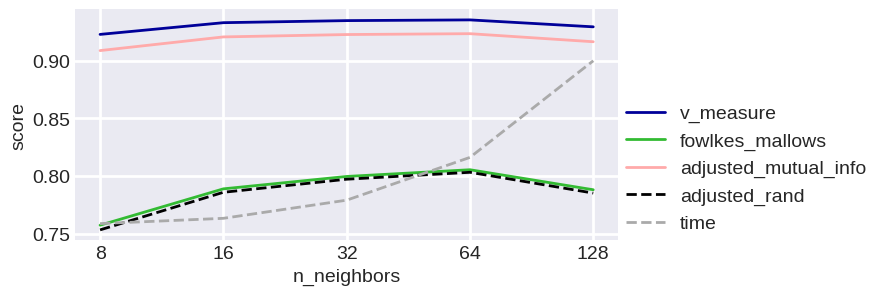

In [79]:
import matplotlib.pyplot as plt

x_axis = parameters_n_neighbors
axis = (1, 2)
x_axis_name = 'n_neighbors'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, np.mean(V, axis=axis), lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, np.mean(FM, axis=axis), lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, np.mean(MI, axis=axis), lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, np.mean(RS, axis=axis), '--', lw=2, c='#000000', label='adjusted_rand')
t = np.mean(T, axis=axis)
t = 0.2 * t / np.max(t) + 0.7
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
plt.xscale('log')
plt.xticks(x_axis, x_axis)
plt.grid(lw=2)
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0));
# plt.ylim([0.4, 0.9])

<ipython-input-75-c47ef13ac210>:22: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 0.1]);


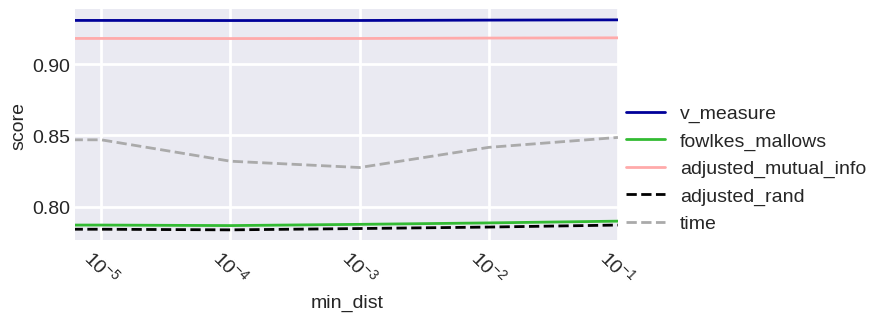

In [75]:
import matplotlib.pyplot as plt

x_axis = parameters_min_dist
axis = (0, 2)
x_axis_name = 'min_dist'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, np.mean(V, axis=axis), lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, np.mean(FM, axis=axis), lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, np.mean(MI, axis=axis), lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, np.mean(RS, axis=axis), '--', lw=2, c='#000000', label='adjusted_rand')
t = np.mean(T, axis=axis)
t = 0.9 * t / np.max(t)
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
# plt.xscale('log')
plt.xticks(x_axis, x_axis, rotation=-45)
plt.grid(lw=2)
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
plt.xscale('log')
plt.xlim([0, 0.1]);
# plt.ylim([0.4, 0.9])

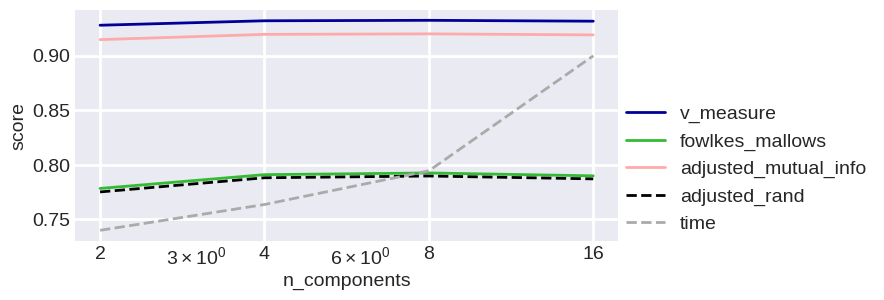

In [72]:
x_axis = parameters_n_components
axis = (0, 1)
x_axis_name = 'n_components'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, np.mean(V, axis=axis), lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, np.mean(FM, axis=axis), lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, np.mean(MI, axis=axis), lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, np.mean(RS, axis=axis), '--', lw=2, c='#000000', label='adjusted_rand')
t = np.mean(T, axis=axis)
t = 0.5 * t / np.max(t) + 0.4
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
plt.xscale('log')
plt.xticks(x_axis, x_axis)
plt.grid(lw=2)
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0));
# plt.ylim([0.5, 0.86])

In [ ]:
ind = np.unravel_index(np.argmax(V, axis=None), V.shape)
ind, parameters_n_neighbors[ind[0]], parameters_min_dist[ind[1]], parameters_n_components[ind[2]]
# оптимальные параметры 32, 0.001, 64
# i=3, j=1, k=2 n_neighbors=32, min_dist=0.001, n_components=64, V=0.875, H=0.8672, C=0.8829, NC=151, FM=0.6578, MI=0.8522, RS=0.6532, T=44.6297

((3, 1, 2), 32, 0.001, 64)

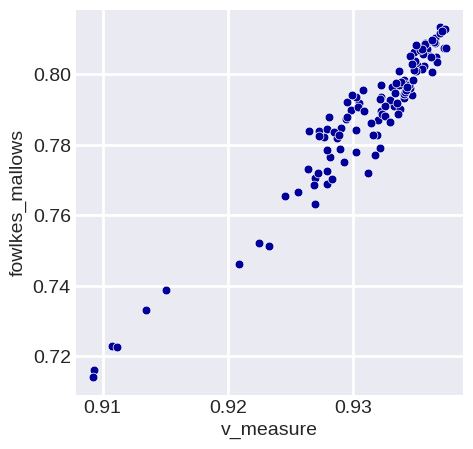

In [89]:
plt.figure(figsize=(5, 5))
plt.scatter(V[:], FM[:], 40, c='#000099', lw=0.5, edgecolor='w') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.xlabel('v_measure')
plt.ylabel('fowlkes_mallows')
plt.grid(lw=2)
#plt.plot(x_axis, np.mean(, axis=axis), lw=2, c='#33BB33', label='')

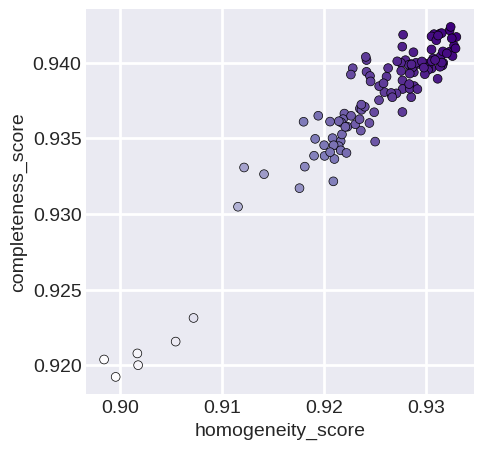

In [95]:
plt.figure(figsize=(5, 5))
plt.scatter(H[:], C[:], 40, V[:], lw=0.5, edgecolor='k', cmap='Purples') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.xlabel('homogeneity_score')
plt.ylabel('completeness_score')
plt.grid(lw=2)

## Сохранение и загрузка результатов вычислений

In [ ]:
# вот так загружается!!!!
data2=np.load('/content/drive/My Drive/clusterdata/climc_umap01_save.npy', allow_pickle=True)
data2[()]['V']

array([[[0.72863071, 0.76873025, 0.79629067, 0.79638837],
        [0.72987159, 0.76734025, 0.801615  , 0.79002547],
        [0.73097589, 0.77712427, 0.80140194, 0.79446269],
        [0.72554144, 0.76614847, 0.79850034, 0.79295122],
        [0.68920995, 0.79258574, 0.80452253, 0.7852513 ],
        [0.62395922, 0.80135545, 0.80499667, 0.79333755]],

       [[0.8372219 , 0.85809069, 0.85585057, 0.85362292],
        [0.84342845, 0.8603936 , 0.85844925, 0.85526746],
        [0.83241773, 0.85748313, 0.85982725, 0.85512323],
        [0.8295484 , 0.85945273, 0.86057443, 0.85372101],
        [0.81316551, 0.85835479, 0.85632409, 0.8567364 ],
        [0.7680138 , 0.86199939, 0.86174292, 0.86293491]],

       [[0.86799137, 0.86719994, 0.86483712, 0.86700827],
        [0.86396809, 0.86809383, 0.86798746, 0.86996162],
        [0.86550419, 0.86877078, 0.8665178 , 0.86779902],
        [0.86601892, 0.86849647, 0.86932292, 0.86507118],
        [0.84350689, 0.86782984, 0.86398858, 0.8714634 ],
        [0

## Аналогично, но с cos-мерой сходства

не стал повторять

In [ ]:
# Эксперименты - пробуем разные параметры UMAP

# параметры
parameters_n_neighbors = [8, 16, 32, 64] #
parameters_min_dist = [0, 0.001, 0.01, 0.1, 0.5] #
parameters_n_components = [32, 64, 128]

# инициализация
V = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
H = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
C = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
NC =  np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)), dtype=int)
FM = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
MI = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
RS = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
T = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))

l = len(np.unique(y))
print (f'число кластеров = {l}')

# перебор
for i, n_neighbors in enumerate(parameters_n_neighbors): # tqdm
  for j, min_dist in enumerate(parameters_min_dist):
    for k, n_components in enumerate(parameters_n_components):

      t0 = time()
      reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric='cosine') # cosine
      embedding = reducer.fit_transform(X)
      clustering_emb = KMeans(n_clusters=l).fit(embedding)
      a = clustering_emb.labels_

      V[i, j, k] = v_measure_score(y, a)
      H[i, j, k] =homogeneity_score(y, a)
      C[i, j, k] = completeness_score(y, a)
      NC[i, j, k] = len(np.unique(a))
      FM[i, j, k] = fowlkes_mallows_score(y, a)
      MI[i, j, k] = adjusted_mutual_info_score(y, a)
      RS[i, j, k] = adjusted_rand_score(y, a)
      T[i, j, k] = time() - t0

      print (f"i={i}, j={j}, k={k} n_neighbors={n_neighbors}, min_dist={min_dist}, n_components={n_components}, V={np.round(V[i, j, k], 4)}, H={np.round(H[i, j, k], 4)}, C={np.round(C[i, j, k], 4)}, NC={np.round(NC[i, j, k], 4)}, FM={np.round(FM[i, j, k], 4)}, MI={np.round(MI[i, j, k], 4)}, RS={np.round(RS[i, j, k], 4)}, T={np.round(T[i, j, k], 4)}")

число кластеров = 151
i=0, j=0, k=0 n_neighbors=8, min_dist=0, n_components=32, V=0.8605, H=0.8437, C=0.878, NC=151, FM=0.6097, MI=0.8367, RS=0.5993, T=32.4696
i=0, j=0, k=1 n_neighbors=8, min_dist=0, n_components=64, V=0.8602, H=0.8439, C=0.8771, NC=151, FM=0.611, MI=0.8363, RS=0.6013, T=35.3802
i=0, j=0, k=2 n_neighbors=8, min_dist=0, n_components=128, V=0.8605, H=0.8388, C=0.8833, NC=151, FM=0.5927, MI=0.8374, RS=0.5779, T=53.1202
i=0, j=1, k=0 n_neighbors=8, min_dist=0.001, n_components=32, V=0.8643, H=0.8512, C=0.8778, NC=151, FM=0.6241, MI=0.8405, RS=0.6164, T=25.9666
i=0, j=1, k=1 n_neighbors=8, min_dist=0.001, n_components=64, V=0.8619, H=0.8474, C=0.8768, NC=151, FM=0.6201, MI=0.838, RS=0.612, T=34.3277
i=0, j=1, k=2 n_neighbors=8, min_dist=0.001, n_components=128, V=0.8564, H=0.832, C=0.8822, NC=151, FM=0.5766, MI=0.833, RS=0.5586, T=54.0489
i=0, j=2, k=0 n_neighbors=8, min_dist=0.01, n_components=32, V=0.858, H=0.8434, C=0.8732, NC=151, FM=0.6075, MI=0.8335, RS=0.5989, T=25.

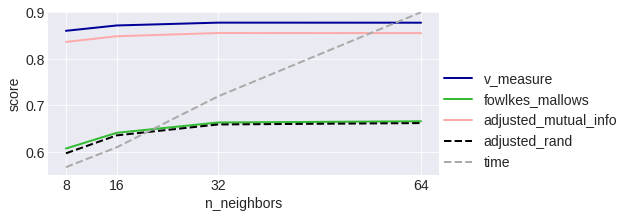

In [ ]:
import matplotlib.pyplot as plt

x_axis = parameters_n_neighbors
axis = (1, 2)
x_axis_name = 'n_neighbors'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, np.mean(V, axis=axis), lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, np.mean(FM, axis=axis), lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, np.mean(MI, axis=axis), lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, np.mean(RS, axis=axis), '--', lw=2, c='#000000', label='adjusted_rand')
t = np.mean(T, axis=axis)
t = 0.9 * t / np.max(t)
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
plt.xticks(x_axis, x_axis)
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
plt.ylim([0.55, 0.9])
# plt.xscale('log')
plt.grid()

(0.6, 0.9)

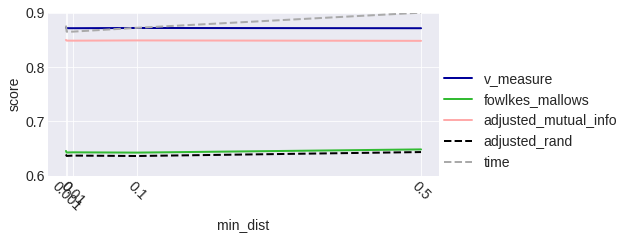

In [ ]:
import matplotlib.pyplot as plt

x_axis = parameters_min_dist
axis = (0, 2)
x_axis_name = 'min_dist'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, np.mean(V, axis=axis), lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, np.mean(FM, axis=axis), lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, np.mean(MI, axis=axis), lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, np.mean(RS, axis=axis), '--', lw=2, c='#000000', label='adjusted_rand')
t = np.mean(T, axis=axis)
t = 0.9 * t / np.max(t)
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
# plt.xscale('log')
plt.xticks(x_axis, x_axis, rotation=-45)
plt.grid()
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
plt.ylim([0.6, 0.9])

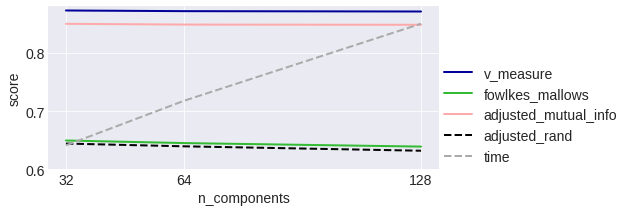

In [ ]:
x_axis = parameters_n_components
axis = (0, 1)
x_axis_name = 'n_components'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, np.mean(V, axis=axis), lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, np.mean(FM, axis=axis), lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, np.mean(MI, axis=axis), lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, np.mean(RS, axis=axis), '--', lw=2, c='#000000', label='adjusted_rand')
t = np.mean(T, axis=axis)
t = 0.5 * t / np.max(t) + 0.35
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
# plt.xscale('log')
plt.xticks(x_axis, x_axis)
plt.grid()
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
plt.ylim([0.6, 0.88])
plt.show()

In [ ]:
ind = np.unravel_index(np.argmax(V, axis=None), V.shape)
ind, parameters_n_neighbors[ind[0]], parameters_min_dist[ind[1]], parameters_n_components[ind[2]]

# i=2, j=0, k=0 n_neighbors=32, min_dist=0, n_components=32, V=0.8818, H=0.8744, C=0.8893, NC=151, FM=0.6744, MI=0.8603, RS=0.6703, T=37.5886

((2, 0, 0), 32, 0, 32)

In [ ]:
# СОХРАНЯЕМ

savedata = {'V': V,
            'H': H,
            'C': C,
            'NC': NC,
            'FM': FM,
            'MI': MI,
            'RS': RS,
            'T': T}

np.save('/content/drive/My Drive/clusterdata/climc_umap02cos_save.npy', savedata)

(15250, 64)


## Подбираем параметры DBSCAN в хорошем пространстве

2

In [103]:
# параметры
parameters_eps = [0.0001, 0.001, 0.01, 0.1] #
parameters_min_samples = [2, 4, 8, 16, 32, 64] #
parameters_metric = ['cosine', 'euclidean']

# пространство для кластеризации
reducer = umap.UMAP(n_neighbors=64, min_dist=0.0001, n_components=4) # , metric='cosine') # cosine
embedding = reducer.fit_transform(X)

# инициализация
V = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
H = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
C = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
NC =  np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)), dtype=int)
FM = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
MI = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
RS = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
T = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))

# перебор
for i, eps in enumerate(parameters_eps): # tqdm
  for j, min_samples in enumerate(parameters_min_samples):
    for k, metric in enumerate(parameters_metric):

      t0 = time.time()
      clustering_emb = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(embedding)
      a = clustering_emb.labels_

      V[i, j, k] = v_measure_score(y, a)
      H[i, j, k] =homogeneity_score(y, a)
      C[i, j, k] = completeness_score(y, a)
      NC[i, j, k] = len(np.unique(a))
      FM[i, j, k] = fowlkes_mallows_score(y, a)
      MI[i, j, k] = adjusted_mutual_info_score(y, a)
      RS[i, j, k] = adjusted_rand_score(y, a)
      T[i, j, k] = time.time() - t0

      print (f"i={i}, j={j}, k={k} eps={eps}, min_samples={min_samples}, metric={metric}, V={np.round(V[i, j, k], 4)}, H={np.round(H[i, j, k], 4)}, C={np.round(C[i, j, k], 4)}, NC={np.round(NC[i, j, k], 4)}, FM={np.round(FM[i, j, k], 4)}, MI={np.round(MI[i, j, k], 4)}, RS={np.round(RS[i, j, k], 4)}, T={np.round(T[i, j, k], 4)}")

i=0, j=0, k=0 eps=0.0001, min_samples=2, metric=cosine, V=0.8784, H=0.8079, C=0.9624, NC=90, FM=0.5395, MI=0.8651, RS=0.4672, T=1.1288
i=0, j=0, k=1 eps=0.0001, min_samples=2, metric=euclidean, V=0.0, H=0.0, C=1.0, NC=1, FM=0.0816, MI=0.0, RS=0.0, T=0.1129
i=0, j=1, k=0 eps=0.0001, min_samples=4, metric=cosine, V=0.8784, H=0.8077, C=0.9627, NC=85, FM=0.5396, MI=0.8652, RS=0.4672, T=1.2431
i=0, j=1, k=1 eps=0.0001, min_samples=4, metric=euclidean, V=0.0, H=0.0, C=1.0, NC=1, FM=0.0816, MI=0.0, RS=0.0, T=0.1522
i=0, j=2, k=0 eps=0.0001, min_samples=8, metric=cosine, V=0.8802, H=0.8112, C=0.9621, NC=86, FM=0.5465, MI=0.867, RS=0.4767, T=1.6054
i=0, j=2, k=1 eps=0.0001, min_samples=8, metric=euclidean, V=0.0, H=0.0, C=1.0, NC=1, FM=0.0816, MI=0.0, RS=0.0, T=0.1538
i=0, j=3, k=0 eps=0.0001, min_samples=16, metric=cosine, V=0.8825, H=0.8153, C=0.9617, NC=88, FM=0.5522, MI=0.8693, RS=0.4844, T=1.4239
i=0, j=3, k=1 eps=0.0001, min_samples=16, metric=euclidean, V=0.0, H=0.0, C=1.0, NC=1, FM=0.08

In [104]:
# eps разный для разных метрик !!!
#

print ('cos')
print (np.round(V[:,:,0], 3) * 100)
print ('L2')
print (np.round(V[:,:,1], 3) * 100)

cos
[[87.8 87.8 88.  88.3 89.1 89.7]
 [74.  74.  74.  74.  74.  74. ]
 [38.8 38.8 38.8 38.8 38.8 38.8]
 [ 2.7  2.7  2.7  2.7  2.7  2.7]]
L2
[[ 0.   0.   0.   0.   0.   0. ]
 [ 6.3  1.5  0.   0.   0.   0. ]
 [67.  61.6 52.7 38.2 18.3  0. ]
 [91.9 92.  92.1 92.1 90.8 84.4]]


In [109]:
print ('L2')
print (NC[:,:,1])

L2


TypeError: 'int' object is not subscriptable

In [110]:
NC

153

In [ ]:
print ('cos')
print (np.round(V[:,:,0], 3) * 100)
print ('L2')
print (np.round(V[:,:,1], 3) * 100)

## DBSCAN в исходном пространстве

In [ ]:
# параметры
parameters_eps = [0.1, 0.2, 0.5, 1.0] # [0.0001, 0.001, 0.01, 0.1] #
parameters_min_samples = [2, 4, 8, 16, 32, 64] #
parameters_metric = ['cosine', 'euclidean']

# инициализация
V = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
H = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
C = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
NC =  np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)), dtype=int)
FM = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
MI = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
RS = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
T = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))

# перебор
for i, eps in enumerate(parameters_eps): # tqdm
  for j, min_samples in enumerate(parameters_min_samples):
    for k, metric in enumerate(parameters_metric):

      t0 = time()
      clustering_emb = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(X)
      a = clustering_emb.labels_

      V[i, j, k] = v_measure_score(y, a)
      H[i, j, k] = homogeneity_score(y, a)
      C[i, j, k] = completeness_score(y, a)
      NC[i, j, k] = len(np.unique(a))
      FM[i, j, k] = fowlkes_mallows_score(y, a)
      MI[i, j, k] = adjusted_mutual_info_score(y, a)
      RS[i, j, k] = adjusted_rand_score(y, a)
      T[i, j, k] = time() - t0

      print (f"i={i}, j={j}, k={k} eps={eps}, min_samples={min_samples}, metric={metric}, V={np.round(V[i, j, k], 4)}, H={np.round(H[i, j, k], 4)}, C={np.round(C[i, j, k], 4)}, NC={np.round(NC[i, j, k], 4)}, FM={np.round(FM[i, j, k], 4)}, MI={np.round(MI[i, j, k], 4)}, RS={np.round(RS[i, j, k], 4)}, T={np.round(T[i, j, k], 4)}")

i=0, j=0, k=0 eps=0.1, min_samples=2, metric=cosine, V=0.5349, H=0.4697, C=0.621, NC=1383, FM=0.063, MI=0.3297, RS=0.0058, T=8.8102
i=0, j=0, k=1 eps=0.1, min_samples=2, metric=euclidean, V=0.0003, H=0.0001, C=0.5068, NC=2, FM=0.0816, MI=0.0, RS=0.0, T=8.3078
i=0, j=1, k=0 eps=0.1, min_samples=4, metric=cosine, V=0.4354, H=0.3254, C=0.6577, NC=495, FM=0.0706, MI=0.2887, RS=0.0036, T=8.4529
i=0, j=1, k=1 eps=0.1, min_samples=4, metric=euclidean, V=0.0, H=0.0, C=1.0, NC=1, FM=0.0816, MI=0.0, RS=0.0, T=9.4362
i=0, j=2, k=0 eps=0.1, min_samples=8, metric=cosine, V=0.2743, H=0.17, C=0.7097, NC=128, FM=0.0782, MI=0.1933, RS=0.002, T=11.5506
i=0, j=2, k=1 eps=0.1, min_samples=8, metric=euclidean, V=0.0, H=0.0, C=1.0, NC=1, FM=0.0816, MI=0.0, RS=0.0, T=8.2109
i=0, j=3, k=0 eps=0.1, min_samples=16, metric=cosine, V=0.1386, H=0.0764, C=0.7412, NC=36, FM=0.0805, MI=0.1004, RS=0.0009, T=5.6239
i=0, j=3, k=1 eps=0.1, min_samples=16, metric=euclidean, V=0.0, H=0.0, C=1.0, NC=1, FM=0.0816, MI=0.0, RS

In [ ]:
# Для стандартной сетки что-то совсем плохо...
print ('cos')
print (np.round(V[:,:,0], 3) * 100)
print ('L2')
print (np.round(V[:,:,1], 3) * 100)

cos
[[ 0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0. ]
 [ 3.1  0.2  0.   0.   0.   0. ]
 [53.5 43.5 27.4 13.9  3.7  0. ]]
L2
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [ ]:
# для новой сетки тоже не очень...
print ('cos')
print (np.round(V[:,:,0], 3) * 100)
print ('L2')
print (np.round(V[:,:,1], 3) * 100)

cos
[[53.5 43.5 27.4 13.9  3.7  0. ]
 [69.4 65.6 58.3 49.  33.  13. ]
 [ 1.8  1.9  2.3  2.5  3.   4.4]
 [ 0.   0.   0.   0.   0.   0. ]]
L2
[[0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [3.  0.2 0.  0.  0.  0. ]]


## Пробуем SVD / PCA вместо UMAP

Тут была какая-то чертовщина с качеством - но в итоге проблема в SVDS

In [ ]:
from scipy.sparse.linalg import svds
U, L, V = svds(X, k=383)

# чтобы правильно упорядочить столбцы, а то порядок не гарантирован
i = np.argsort(-L)
U = U[:, i]

In [ ]:
L = L[i]

In [ ]:
# А это PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=150)
U = pca.fit_transform(X)

In [ ]:
# случайная проекция
U = (X @ np.random.randn(768, 150))
# X.shape 15250, 768)

In [ ]:
X.shape

NameError: ignored

In [ ]:
%%time
# t-SNE
from sklearn.manifold import TSNE

U = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X)

# from fastTSNE import TSNE
# 1min 46s

CPU times: user 1min 48s, sys: 1.12 s, total: 1min 49s
Wall time: 1min 45s


In [ ]:
from time import time

In [ ]:
X.shape

(15250, 768)

In [ ]:
# Эксперименты - пробуем разные параметры UMAP

# параметры

#parameters_n_components = [10, 25, 50, 75, 100, 125, 150]
# parameters_n_components = [1, 2]
parameters_n_components = [2, 4, 8, 16, 32, 64]

# инициализация
V = np.zeros(( len(parameters_n_components)))
H = np.zeros(( len(parameters_n_components)))
C = np.zeros(( len(parameters_n_components)))
NC =  np.zeros(( len(parameters_n_components)), dtype=int)
FM = np.zeros(( len(parameters_n_components)))
MI = np.zeros(( len(parameters_n_components)))
RS = np.zeros(( len(parameters_n_components)))
T = np.zeros(( len(parameters_n_components)))

l = len(np.unique(y))
print (f'число кластеров = {l}')

# перебор
for k, n_components in enumerate(parameters_n_components):
  t0 = time()
  reducer = umap.UMAP(n_neighbors=32, min_dist=0.1, n_components=n_components, metric='euclidean') # cosine
  U = reducer.fit_transform(X)
  clustering_emb = KMeans(n_clusters=l).fit(U)
  #clustering_emb = KMeans(n_clusters=l).fit(U[:, :n_components])
  ########### clustering_emb = KMeans(n_clusters=l).fit(U[:, :n_components] @ np.diag(np.sqrt(L[:n_components])))
  a = clustering_emb.labels_

  V[k] = v_measure_score(y, a)
  H[k] =homogeneity_score(y, a)
  C[k] = completeness_score(y, a)
  NC[k] = len(np.unique(a))
  FM[k] = fowlkes_mallows_score(y, a)
  MI[k] = adjusted_mutual_info_score(y, a)
  RS[k] = adjusted_rand_score(y, a)
  T[k] = time() - t0

  print (f"k={k}, n_components={n_components}, V={np.round(V[k], 4)}, H={np.round(H[k], 4)}, C={np.round(C[k], 4)}, NC={np.round(NC[k], 4)}, FM={np.round(FM[k], 4)}, MI={np.round(MI[k], 4)}, RS={np.round(RS[k], 4)}, T={np.round(T[k], 4)}")

число кластеров = 151
k=0, n_components=2, V=0.9337, H=0.9289, C=0.9385, NC=151, FM=0.7985, MI=0.9214, RS=0.7962, T=44.7608
k=1, n_components=4, V=0.9343, H=0.9296, C=0.939, NC=151, FM=0.8003, MI=0.9221, RS=0.7981, T=25.5373
k=2, n_components=8, V=0.9318, H=0.9265, C=0.9371, NC=151, FM=0.7898, MI=0.9191, RS=0.7873, T=27.6455
k=3, n_components=16, V=0.9368, H=0.9305, C=0.9432, NC=151, FM=0.8035, MI=0.9253, RS=0.8007, T=38.6579
k=4, n_components=32, V=0.9345, H=0.9302, C=0.9388, NC=151, FM=0.8015, MI=0.9223, RS=0.7995, T=45.2
k=5, n_components=64, V=0.9326, H=0.9264, C=0.9389, NC=151, FM=0.7876, MI=0.9202, RS=0.7847, T=70.4475


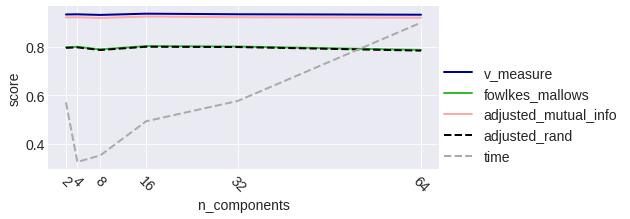

In [ ]:
import matplotlib.pyplot as plt

x_axis = parameters_n_components
# axis = (0, 2)
x_axis_name = 'n_components'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, V, lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, FM, lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, MI, lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, RS, '--', lw=2, c='#000000', label='adjusted_rand')
# t = np.mean(T, axis=axis)
t = T.copy()
t = 0.9 * t / np.max(t)
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
# plt.xscale('log')
plt.xticks(x_axis, x_axis, rotation=-45)
plt.grid()
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
# plt.ylim([0.6, 0.9])

In [ ]:
# вывод
# иcправил SVD

число кластеров = 151
k=0, n_components=10, V=0.7347, H=0.7316, C=0.7378, NC=151, FM=0.4166, MI=0.6853, RS=0.4122, T=16.8355
k=1, n_components=25, V=0.8243, H=0.8207, C=0.828, NC=151, FM=0.5776, MI=0.7916, RS=0.5742, T=10.3723
k=2, n_components=50, V=0.8286, H=0.8229, C=0.8343, NC=151, FM=0.5802, MI=0.797, RS=0.576, T=22.3754
k=3, n_components=75, V=0.8208, H=0.8145, C=0.8272, NC=151, FM=0.5574, MI=0.7879, RS=0.5528, T=19.366
k=4, n_components=100, V=0.8204, H=0.8118, C=0.8291, NC=151, FM=0.5565, MI=0.7879, RS=0.5506, T=16.752
k=5, n_components=125, V=0.802, H=0.793, C=0.8113, NC=151, FM=0.5138, MI=0.7662, RS=0.5072, T=20.612
k=6, n_components=150, V=0.8027, H=0.79, C=0.8158, NC=151, FM=0.5031, MI=0.7678, RS=0.4936, T=23.9631


# X @ L

число кластеров = 151
k=0, n_components=10, V=0.7513, H=0.7477, C=0.7549, NC=151, FM=0.449, MI=0.7051, RS=0.4447, T=12.3307
k=1, n_components=25, V=0.8322, H=0.827, C=0.8375, NC=151, FM=0.5828, MI=0.8012, RS=0.5788, T=9.9408
k=2, n_components=50, V=0.8497, H=0.8443, C=0.8552, NC=151, FM=0.6171, MI=0.8219, RS=0.6132, T=10.9739
k=3, n_components=75, V=0.8568, H=0.8504, C=0.8634, NC=151, FM=0.6231, MI=0.8306, RS=0.6189, T=12.988
k=4, n_components=100, V=0.8602, H=0.8543, C=0.8661, NC=151, FM=0.6336, MI=0.8344, RS=0.6297, T=14.8174
k=5, n_components=125, V=0.8634, H=0.8555, C=0.8714, NC=151, FM=0.63, MI=0.8384, RS=0.6249, T=18.6306
k=6, n_components=150, V=0.8603, H=0.8538, C=0.8669, NC=151, FM=0.6294, MI=0.8346, RS=0.6252, T=29.2496

# X @ sqrt(L)

число кластеров = 151
k=0, n_components=10, V=0.7455, H=0.7423, C=0.7487, NC=151, FM=0.4421, MI=0.6981, RS=0.4379, T=19.2563
k=1, n_components=25, V=0.8317, H=0.8284, C=0.835, NC=151, FM=0.5919, MI=0.8003, RS=0.5887, T=10.4233
k=2, n_components=50, V=0.8426, H=0.8367, C=0.8487, NC=151, FM=0.606, MI=0.8137, RS=0.6018, T=10.6263
k=3, n_components=75, V=0.8378, H=0.8312, C=0.8444, NC=151, FM=0.5804, MI=0.808, RS=0.5758, T=12.9337
k=4, n_components=100, V=0.843, H=0.8362, C=0.8499, NC=151, FM=0.597, MI=0.8142, RS=0.5924, T=14.9503
k=5, n_components=125, V=0.8435, H=0.8348, C=0.8524, NC=151, FM=0.5836, MI=0.8151, RS=0.5776, T=18.3147
k=6, n_components=150, V=0.8394, H=0.8303, C=0.8487, NC=151, FM=0.5804, MI=0.8104, RS=0.5744, T=22.4558

# PCA
число кластеров = 151
k=0, n_components=10, V=0.7534, H=0.7498, C=0.757, NC=151, FM=0.4486, MI=0.7075, RS=0.4443, T=23.7057
k=1, n_components=25, V=0.8341, H=0.8299, C=0.8383, NC=151, FM=0.5969, MI=0.8033, RS=0.5934, T=16.5884
k=2, n_components=50, V=0.8565, H=0.8508, C=0.8623, NC=151, FM=0.6275, MI=0.8301, RS=0.6236, T=17.5572
k=3, n_components=75, V=0.865, H=0.859, C=0.871, NC=151, FM=0.6432, MI=0.8401, RS=0.6392, T=13.6609
k=4, n_components=100, V=0.8613, H=0.8548, C=0.8679, NC=151, FM=0.6302, MI=0.8358, RS=0.626, T=14.1136
k=5, n_components=125, V=0.8578, H=0.8501, C=0.8657, NC=151, FM=0.622, MI=0.832, RS=0.6173, T=16.7779
k=6, n_components=150, V=0.8591, H=0.8506, C=0.8678, NC=151, FM=0.6182, MI=0.8335, RS=0.6127, T=21.9443

# случайные проекции (но тут T5)
k=0, n_components=10, V=0.5316, H=0.5299, C=0.5332, NC=151, FM=0.2017, MI=0.4439, RS=0.1961, T=21.8271
k=1, n_components=25, V=0.7351, H=0.7329, C=0.7373, NC=151, FM=0.4707, MI=0.6855, RS=0.4669, T=13.983
k=2, n_components=50, V=0.8419, H=0.8392, C=0.8446, NC=151, FM=0.6417, MI=0.8123, RS=0.639, T=14.4978
k=3, n_components=75, V=0.8774, H=0.8726, C=0.8823, NC=151, FM=0.684, MI=0.8547, RS=0.6809, T=14.5058
k=4, n_components=100, V=0.895, H=0.8908, C=0.8993, NC=151, FM=0.7152, MI=0.8755, RS=0.7125, T=15.9028
k=5, n_components=125, V=0.893, H=0.8882, C=0.8979, NC=151, FM=0.7072, MI=0.8732, RS=0.7043, T=18.1399
k=6, n_components=150, V=0.9096, H=0.9045, C=0.9147, NC=151, FM=0.745, MI=0.8928, RS=0.7423, T=20.5817

# t-SNE
k=0, n_components=1, V=0.5666, H=0.5637, C=0.5695, NC=151, FM=0.1256, MI=0.4864, RS=0.1193, T=2.729
k=1, n_components=2, V=0.9186, H=0.9166, C=0.9205, NC=151, FM=0.7744, MI=0.9033, RS=0.7727, T=3.378

# T5 + UMAP
число кластеров = 151
k=0, n_components=2, V=0.9337, H=0.9289, C=0.9385, NC=151, FM=0.7985, MI=0.9214, RS=0.7962, T=44.7608
k=1, n_components=4, V=0.9343, H=0.9296, C=0.939, NC=151, FM=0.8003, MI=0.9221, RS=0.7981, T=25.5373
k=2, n_components=8, V=0.9318, H=0.9265, C=0.9371, NC=151, FM=0.7898, MI=0.9191, RS=0.7873, T=27.6455
k=3, n_components=16, V=0.9368, H=0.9305, C=0.9432, NC=151, FM=0.8035, MI=0.9253, RS=0.8007, T=38.6579
k=4, n_components=32, V=0.9345, H=0.9302, C=0.9388, NC=151, FM=0.8015, MI=0.9223, RS=0.7995, T=45.2
k=5, n_components=64, V=0.9326, H=0.9264, C=0.9389, NC=151, FM=0.7876, MI=0.9202, RS=0.7847, T=70.4475

(15250, 384)

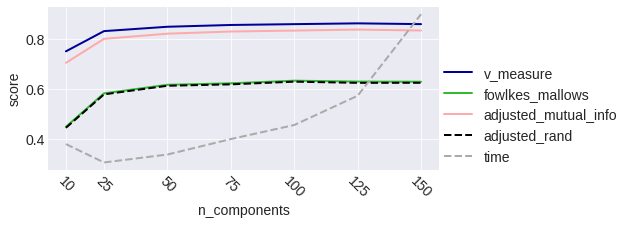

In [ ]:
# ЕСЛИ УМНОЖАТЬ НА ДИАГОНАЛЬНУЮ МАТРИЦУ L

import matplotlib.pyplot as plt

x_axis = parameters_n_components
# axis = (0, 2)
x_axis_name = 'n_components'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, V, lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, FM, lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, MI, lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, RS, '--', lw=2, c='#000000', label='adjusted_rand')
# t = np.mean(T, axis=axis)
t = T.copy()
t = 0.9 * t / np.max(t)
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
# plt.xscale('log')
plt.xticks(x_axis, x_axis, rotation=-45)
plt.grid()
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
# plt.ylim([0.6, 0.9])

### На части делать UMAP

In [ ]:
# Эксперименты - пробуем разные параметры UMAP

# параметры

#parameters_n_components = [10, 25, 50, 75, 100, 125, 150]
# parameters_n_components = [1, 2]
parameters_n_components = [2, 4, 8, 16, 32, 64]

# инициализация
V = np.zeros(( len(parameters_n_components)))
H = np.zeros(( len(parameters_n_components)))
C = np.zeros(( len(parameters_n_components)))
NC =  np.zeros(( len(parameters_n_components)), dtype=int)
FM = np.zeros(( len(parameters_n_components)))
MI = np.zeros(( len(parameters_n_components)))
RS = np.zeros(( len(parameters_n_components)))
T = np.zeros(( len(parameters_n_components)))

V2 = np.zeros(( len(parameters_n_components)))
H2 = np.zeros(( len(parameters_n_components)))
C2 = np.zeros(( len(parameters_n_components)))
NC2 =  np.zeros(( len(parameters_n_components)), dtype=int)
FM2 = np.zeros(( len(parameters_n_components)))
MI2 = np.zeros(( len(parameters_n_components)))
RS2 = np.zeros(( len(parameters_n_components)))
T2 = np.zeros(( len(parameters_n_components)))

l = len(np.unique(y))
print (f'число кластеров = {l}')

# перебор
for k, n_components in enumerate(parameters_n_components):
  t0 = time()
  reducer = umap.UMAP(n_neighbors=32, min_dist=0.1, n_components=n_components, metric='euclidean') # cosine
  reducer.fit(X[:2000, :])
  U = reducer.transform(X)
  clustering_emb = KMeans(n_clusters=l).fit(U)
  #clustering_emb = KMeans(n_clusters=l).fit(U[:, :n_components])
  ########### clustering_emb = KMeans(n_clusters=l).fit(U[:, :n_components] @ np.diag(np.sqrt(L[:n_components])))
  a = clustering_emb.labels_

  V[k],V2[k]  = v_measure_score(y[:2000], a[:2000]), v_measure_score(y[2000:], a[2000:])
  H[k], H2[k] = homogeneity_score(y[:2000], a[:2000]), homogeneity_score(y[2000:], a[2000:])
  C[k], C2[k] = completeness_score(y[:2000], a[:2000]), completeness_score(y[2000:], a[2000:])
  NC[k], NC2[k] = len(np.unique(a[:2000])), len(np.unique(a[2000:]))
  FM[k], FM2[k] = fowlkes_mallows_score(y[:2000], a[:2000]), fowlkes_mallows_score(y[2000:], a[2000:])
  MI[k], MI2[k] = adjusted_mutual_info_score(y[:2000], a[:2000]), adjusted_mutual_info_score(y[2000:], a[2000:])
  RS[k], RS2[k] = adjusted_rand_score(y[:2000], a[:2000]), adjusted_rand_score(y[2000:], a[2000:])
  T[k] = time() - t0

  print (f"k={k}, n_components={n_components}, V={np.round(V[k], 4)}, H={np.round(H[k], 4)}, C={np.round(C[k], 4)}, NC={np.round(NC[k], 4)}, FM={np.round(FM[k], 4)}, MI={np.round(MI[k], 4)}, RS={np.round(RS[k], 4)}, T={np.round(T[k], 4)}")
  print (f" V={np.round(V2[k], 4)}, H={np.round(H2[k], 4)}, C={np.round(C2[k], 4)}, NC={np.round(NC2[k], 4)}, FM={np.round(FM2[k], 4)}, MI={np.round(MI2[k], 4)}, RS={np.round(RS2[k], 4)}, T={np.round(T2[k], 4)}")

число кластеров = 151
k=0, n_components=2, V=0.8795, H=0.9806, C=0.7973, NC=47, FM=0.7042, MI=0.8705, RS=0.6596, T=106.7456
 V=0.4597, H=0.448, C=0.4721, NC=151, FM=0.1368, MI=0.3677, RS=0.1199, T=0.0
k=1, n_components=4, V=0.9448, H=0.9756, C=0.9159, NC=29, FM=0.8808, MI=0.9422, RS=0.8731, T=119.3989
 V=0.5093, H=0.4823, C=0.5396, NC=151, FM=0.1646, MI=0.4323, RS=0.1327, T=0.0
k=2, n_components=8, V=0.9518, H=0.9776, C=0.9273, NC=28, FM=0.9041, MI=0.9496, RS=0.8982, T=162.7389
 V=0.5227, H=0.4966, C=0.5518, NC=151, FM=0.1769, MI=0.4486, RS=0.1493, T=0.0
k=3, n_components=16, V=0.9488, H=0.9779, C=0.9214, NC=26, FM=0.8972, MI=0.9466, RS=0.8901, T=259.9015
 V=0.527, H=0.4979, C=0.5598, NC=151, FM=0.1724, MI=0.4524, RS=0.1384, T=0.0
k=4, n_components=32, V=0.9459, H=0.9737, C=0.9197, NC=26, FM=0.8929, MI=0.9436, RS=0.8856, T=441.368
 V=0.5282, H=0.4989, C=0.5613, NC=151, FM=0.1755, MI=0.4541, RS=0.1412, T=0.0
k=5, n_components=64, V=0.9593, H=0.9773, C=0.942, NC=27, FM=0.9199, MI=0.9576,

## UMAP + Standartisation + k-means

Перебираем параметры UMAP


Сначала стандартизация после UMAP - тут почти также, как без стандартизации!

In [ ]:
# Эксперименты - пробуем разные параметры UMAP

# Стандартизация после UMAP!

# параметры
parameters_n_neighbors = [16, 32, 64] # 4, 8,
parameters_min_dist = [0, 0.001, 0.01] # , 0.1, 0.5, 1.0
parameters_n_components = [32, 64, 128] # 2,

# инициализация
V = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
H = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
C = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
NC =  np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)), dtype=int)
FM = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
MI = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
RS = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
T = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))

l = len(np.unique(y))
print (f'число кластеров = {l}')

# СТАНДАРТИЗАЦИЯ
scaler = StandardScaler()

# перебор
for i, n_neighbors in enumerate(parameters_n_neighbors): # tqdm
  for j, min_dist in enumerate(parameters_min_dist):
    for k, n_components in enumerate(parameters_n_components):

      t0 = time()
      reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric='euclidean') # cosine
      embedding = reducer.fit_transform(X)
      embedding = scaler.fit_transform(embedding)
      clustering_emb = KMeans(n_clusters=l).fit(embedding)
      a = clustering_emb.labels_

      V[i, j, k] = v_measure_score(y, a)
      H[i, j, k] =homogeneity_score(y, a)
      C[i, j, k] = completeness_score(y, a)
      NC[i, j, k] = len(np.unique(a))
      FM[i, j, k] = fowlkes_mallows_score(y, a)
      MI[i, j, k] = adjusted_mutual_info_score(y, a)
      RS[i, j, k] = adjusted_rand_score(y, a)
      T[i, j, k] = time() - t0

      print (f"i={i}, j={j}, k={k} n_neighbors={n_neighbors}, min_dist={min_dist}, n_components={n_components}, V={np.round(V[i, j, k], 4)}, H={np.round(H[i, j, k], 4)}, C={np.round(C[i, j, k], 4)}, NC={np.round(NC[i, j, k], 4)}, FM={np.round(FM[i, j, k], 4)}, MI={np.round(MI[i, j, k], 4)}, RS={np.round(RS[i, j, k], 4)}, T={np.round(T[i, j, k], 4)}")

число кластеров = 151
i=0, j=0, k=0 n_neighbors=16, min_dist=0, n_components=32, V=0.8692, H=0.8583, C=0.8804, NC=151, FM=0.6344, MI=0.8459, RS=0.6279, T=36.0171
i=0, j=0, k=1 n_neighbors=16, min_dist=0, n_components=64, V=0.8658, H=0.8557, C=0.8762, NC=151, FM=0.6257, MI=0.8418, RS=0.6197, T=37.2969
i=0, j=0, k=2 n_neighbors=16, min_dist=0, n_components=128, V=0.8606, H=0.845, C=0.8769, NC=151, FM=0.5899, MI=0.8364, RS=0.5793, T=55.4245
i=0, j=1, k=0 n_neighbors=16, min_dist=0.001, n_components=32, V=0.8681, H=0.8575, C=0.879, NC=151, FM=0.631, MI=0.8445, RS=0.6245, T=28.4759
i=0, j=1, k=1 n_neighbors=16, min_dist=0.001, n_components=64, V=0.8669, H=0.8559, C=0.8782, NC=151, FM=0.6195, MI=0.843, RS=0.6123, T=37.8797
i=0, j=1, k=2 n_neighbors=16, min_dist=0.001, n_components=128, V=0.8658, H=0.8505, C=0.8817, NC=151, FM=0.6055, MI=0.8424, RS=0.5948, T=54.8898
i=0, j=2, k=0 n_neighbors=16, min_dist=0.01, n_components=32, V=0.8694, H=0.8585, C=0.8806, NC=151, FM=0.6344, MI=0.8461, RS=0.6

In [ ]:
ind = np.unravel_index(np.argmax(V, axis=None), V.shape)
ind, parameters_n_neighbors[ind[0]], parameters_min_dist[ind[1]], parameters_n_components[ind[2]]

# i=1, j=1, k=0 n_neighbors=32, min_dist=0.001, n_components=32, V=0.87, H=0.8607, C=0.8794, NC=151, FM=0.6396, MI=0.8465, RS=0.634, T=33.2844

((1, 1, 0), 32, 0.001, 32)

In [ ]:
savedata = {'V': V,
            'H': H,
            'C': C,
            'NC': NC,
            'FM': FM,
            'MI': MI,
            'RS': RS,
            'T': T}

np.save('/content/drive/My Drive/clusterdata/climc_umapstandart03_save.npy', savedata)

(0.4, 0.9)

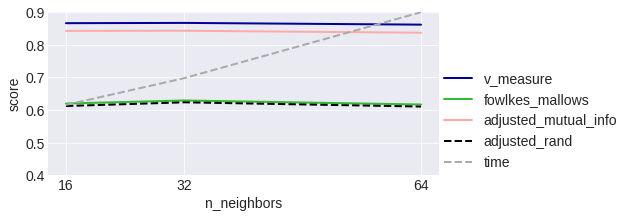

In [ ]:
import matplotlib.pyplot as plt

x_axis = parameters_n_neighbors
axis = (1, 2)
x_axis_name = 'n_neighbors'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, np.mean(V, axis=axis), lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, np.mean(FM, axis=axis), lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, np.mean(MI, axis=axis), lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, np.mean(RS, axis=axis), '--', lw=2, c='#000000', label='adjusted_rand')
t = np.mean(T, axis=axis)
t = 0.9 * t / np.max(t)
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
# plt.xscale('log')
plt.xticks(x_axis, x_axis)
plt.grid()
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
plt.ylim([0.4, 0.9])

## Стандартизация + UMAP + k-means

In [ ]:
# Эксперименты - пробуем разные параметры UMAP

# СТАНДАРТИЗАЦИЯ
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)


# параметры
parameters_n_neighbors = [16, 32, 64] # 4, 8,
parameters_min_dist = [0, 0.001, 0.01] # , 0.1, 0.5, 1.0
parameters_n_components = [32, 64, 128] # 2,

# инициализация
V = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
H = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
C = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
NC =  np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)), dtype=int)
FM = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
MI = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
RS = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
T = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))

l = len(np.unique(y))
print (f'число кластеров = {l}')



# перебор
for i, n_neighbors in enumerate(parameters_n_neighbors): # tqdm
  for j, min_dist in enumerate(parameters_min_dist):
    for k, n_components in enumerate(parameters_n_components):

      t0 = time()
      reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric='euclidean') # cosine
      embedding = reducer.fit_transform(X_scale)
      clustering_emb = KMeans(n_clusters=l).fit(embedding)
      a = clustering_emb.labels_

      V[i, j, k] = v_measure_score(y, a)
      H[i, j, k] =homogeneity_score(y, a)
      C[i, j, k] = completeness_score(y, a)
      NC[i, j, k] = len(np.unique(a))
      FM[i, j, k] = fowlkes_mallows_score(y, a)
      MI[i, j, k] = adjusted_mutual_info_score(y, a)
      RS[i, j, k] = adjusted_rand_score(y, a)
      T[i, j, k] = time() - t0

      print (f"i={i}, j={j}, k={k} n_neighbors={n_neighbors}, min_dist={min_dist}, n_components={n_components}, V={np.round(V[i, j, k], 4)}, H={np.round(H[i, j, k], 4)}, C={np.round(C[i, j, k], 4)}, NC={np.round(NC[i, j, k], 4)}, FM={np.round(FM[i, j, k], 4)}, MI={np.round(MI[i, j, k], 4)}, RS={np.round(RS[i, j, k], 4)}, T={np.round(T[i, j, k], 4)}")

число кластеров = 151
i=0, j=0, k=0 n_neighbors=16, min_dist=0, n_components=32, V=0.8631, H=0.8528, C=0.8736, NC=151, FM=0.6242, MI=0.8386, RS=0.6181, T=35.4864
i=0, j=0, k=1 n_neighbors=16, min_dist=0, n_components=64, V=0.8646, H=0.8545, C=0.8749, NC=151, FM=0.6289, MI=0.8403, RS=0.623, T=36.5384
i=0, j=0, k=2 n_neighbors=16, min_dist=0, n_components=128, V=0.8652, H=0.8536, C=0.877, NC=151, FM=0.6221, MI=0.8412, RS=0.615, T=57.1516
i=0, j=1, k=0 n_neighbors=16, min_dist=0.001, n_components=32, V=0.8662, H=0.8571, C=0.8755, NC=151, FM=0.6347, MI=0.8421, RS=0.6293, T=27.5982
i=0, j=1, k=1 n_neighbors=16, min_dist=0.001, n_components=64, V=0.8657, H=0.8559, C=0.8757, NC=151, FM=0.6289, MI=0.8415, RS=0.6229, T=37.2388
i=0, j=1, k=2 n_neighbors=16, min_dist=0.001, n_components=128, V=0.867, H=0.8542, C=0.8801, NC=151, FM=0.6258, MI=0.8436, RS=0.618, T=55.145
i=0, j=2, k=0 n_neighbors=16, min_dist=0.01, n_components=32, V=0.8658, H=0.8561, C=0.8757, NC=151, FM=0.6306, MI=0.8417, RS=0.624

In [ ]:
ind = np.unravel_index(np.argmax(V, axis=None), V.shape)
ind, parameters_n_neighbors[ind[0]], parameters_min_dist[ind[1]], parameters_n_components[ind[2]]
# i=2, j=1, k=1 n_neighbors=64, min_dist=0.001, n_components=64, V=0.8682, H=0.8609, C=0.8757, NC=151, FM=0.6503, MI=0.8443, RS=0.646, T=57.2074

((2, 1, 1), 64, 0.001, 64)

(0.4, 0.9)

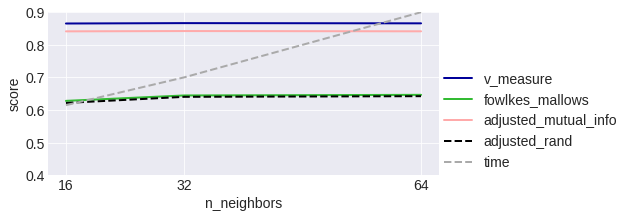

In [ ]:
import matplotlib.pyplot as plt

x_axis = parameters_n_neighbors
axis = (1, 2)
x_axis_name = 'n_neighbors'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, np.mean(V, axis=axis), lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, np.mean(FM, axis=axis), lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, np.mean(MI, axis=axis), lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, np.mean(RS, axis=axis), '--', lw=2, c='#000000', label='adjusted_rand')
t = np.mean(T, axis=axis)
t = 0.9 * t / np.max(t)
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
# plt.xscale('log')
plt.xticks(x_axis, x_axis)
plt.grid()
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
plt.ylim([0.4, 0.9])

In [ ]:
savedata = {'V': V,
            'H': H,
            'C': C,
            'NC': NC,
            'FM': FM,
            'MI': MI,
            'RS': RS,
            'T': T}

np.save('/content/drive/My Drive/clusterdata/climc_standartumap04_save.npy', savedata)

In [ ]:
i=0, j=0, k=0 n_neighbors=4, min_dist=0, n_components=2, V=0.7286, H=0.721, C=0.7364, NC=151, FM=0.3702, MI=0.6795, RS=0.3638, T=15.6796
i=0, j=0, k=1 n_neighbors=4, min_dist=0, n_components=32, V=0.7687, H=0.7447, C=0.7944, NC=151, FM=0.3993, MI=0.7301, RS=0.3761, T=24.0184
i=0, j=0, k=2 n_neighbors=4, min_dist=0, n_components=64, V=0.7963, H=0.7675, C=0.8273, NC=151, FM=0.4585, MI=0.7641, RS=0.4345, T=34.4921
i=0, j=0, k=3 n_neighbors=4, min_dist=0, n_components=128, V=0.7964, H=0.7646, C=0.831, NC=151, FM=0.4433, MI=0.7643, RS=0.4137, T=56.2192
i=0, j=1, k=0 n_neighbors=4, min_dist=0.001, n_components=2, V=0.7299, H=0.7228, C=0.7371, NC=151, FM=0.3744, MI=0.6807, RS=0.3683, T=15.0336
i=0, j=1, k=1 n_neighbors=4, min_dist=0.001, n_components=32, V=0.7673, H=0.7456, C=0.7904, NC=151, FM=0.3994, MI=0.7278, RS=0.3788, T=23.1076
i=0, j=1, k=2 n_neighbors=4, min_dist=0.001, n_components=64, V=0.8016, H=0.7721, C=0.8335, NC=151, FM=0.4645, MI=0.7706, RS=0.44, T=33.6041
i=0, j=1, k=3 n_neighbors=4, min_dist=0.001, n_components=128, V=0.79, H=0.7566, C=0.8265, NC=151, FM=0.4257, MI=0.7571, RS=0.3929, T=55.3757
i=0, j=2, k=0 n_neighbors=4, min_dist=0.01, n_components=2, V=0.731, H=0.7243, C=0.7377, NC=151, FM=0.377, MI=0.682, RS=0.3712, T=13.0621
i

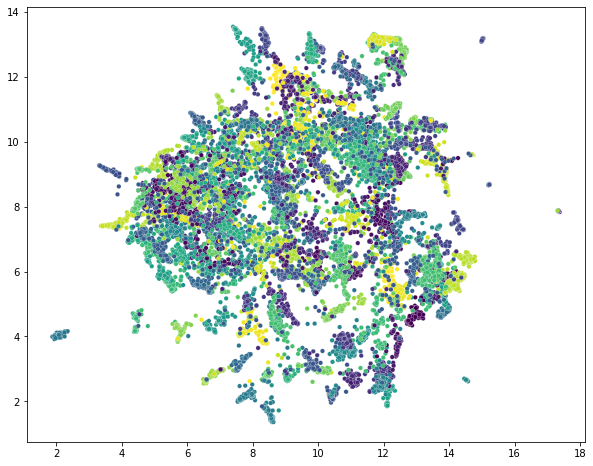

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0],
            embedding[:, 1],
            20,
            y,
            lw=0.2,
            edgecolor='w')

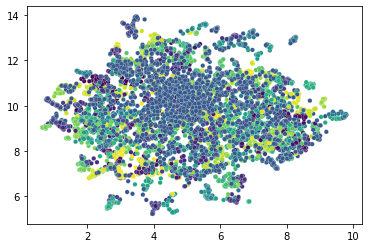

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(embedding[:, 0],
            embedding[:, 1],
            20,
            y,
            lw=0.2,
            edgecolor='w')

# Автокодировщик

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import torch.nn as nn

enc = nn.Sequential(nn.Linear(768, 700, bias=False),
                    nn.BatchNorm1d(700),
                    nn.ReLU(),
                    nn.Linear(700, 500, bias=False),
                    nn.BatchNorm1d(500),
                    nn.ReLU(),
                    nn.Linear(500, 300, bias=False),
                    nn.BatchNorm1d(300),
                    nn.ReLU(),
                    nn.Linear(300, 100, bias=False),
                    nn.BatchNorm1d(100),
                    nn.ReLU(),
                    nn.Linear(100, 64))

dec = nn.Sequential(nn.Linear(64, 100, bias=False),
                    nn.BatchNorm1d(100),
                    nn.ReLU(),
                    nn.Linear(100, 300, bias=False),
                    nn.BatchNorm1d(300),
                    nn.ReLU(),
                    nn.Linear(300, 500, bias=False),
                    nn.BatchNorm1d(500),
                    nn.ReLU(),
                    nn.Linear(500, 700, bias=False),
                    nn.BatchNorm1d(700),
                    nn.ReLU(),
                    nn.Linear(700, 768))



class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = enc
        self.decoder = dec

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def get_n_params(model):
    """
    число параметров
    """
    np = 0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

model = Autoencoder().to(device)
criterion = nn.MSELoss()

get_n_params(model)

2155232

In [ ]:
torch.tensor(y).shape

torch.Size([15250])

In [ ]:
import torch.utils.data as data

class MyDataset(data.Dataset):

    def __init__(self, X, y):
        """
        Inputs:
            size - число точек
            std - уровень шума
        """
        super().__init__()
        self.X = torch.tensor(X.astype(np.float32))
        self.y = torch.tensor(y.astype(np.int)) # тут надо тип сменить


    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # idx-й элемент датасета
        return self.X[idx], self.y[idx]

data_loader = data.DataLoader(MyDataset(X, y), batch_size=1024, shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


In [ ]:
learning_rate = 3e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

num_epochs = 500
losses = []
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    total_loss = 0
    i_batch = 0
    for data in data_loader:
        x, _ = data
        x = x.to(device)
        # ===================forward=====================
        output = model(x)
        loss = criterion(output, x)
        total_loss += loss.item()
        i_batch += 1
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    if np.mod(epoch + 1, 100)==0:
      print(f'epoch [{epoch + 1}/{num_epochs}], loss:{total_loss/i_batch:.4f}')
    losses.append(total_loss/i_batch)


# loss:0.0175

epoch [100/500], loss:0.0152
epoch [200/500], loss:0.0155
epoch [300/500], loss:0.0098
epoch [400/500], loss:0.0094
epoch [500/500], loss:0.0103


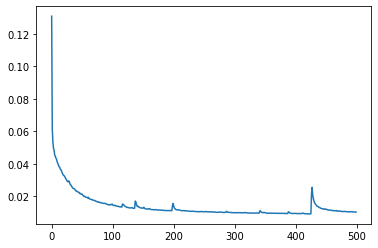

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

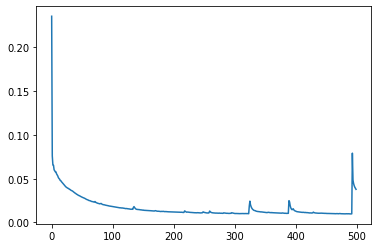

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [ ]:
learning_rate = 1e-4

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

num_epochs = 100
losses = []
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    total_loss = 0
    i_batch = 0
    for data in data_loader:
        x, _ = data
        x = x.to(device)
        # ===================forward=====================
        output = model(x)
        loss = criterion(output, x)
        total_loss += loss.item()
        i_batch += 1
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    if np.mod(epoch + 1, 10)==0:
      print(f'epoch [{epoch + 1}/{num_epochs}], loss:{total_loss/i_batch:.4f}')
    losses.append(total_loss/i_batch)



epoch [10/100], loss:0.0198
epoch [20/100], loss:0.0198
epoch [30/100], loss:0.0197
epoch [40/100], loss:0.0197
epoch [50/100], loss:0.0197
epoch [60/100], loss:0.0197
epoch [70/100], loss:0.0197
epoch [80/100], loss:0.0197
epoch [90/100], loss:0.0197
epoch [100/100], loss:0.0197


In [ ]:
((x.abs() > 0.01) + 0.0).mean(), ((output.abs() > 0.01) + 0.0).mean()

(tensor(0.9767, device='cuda:0'), tensor(0.9759, device='cuda:0'))

In [ ]:
z = model.encoder(x)

In [ ]:
((z.abs() > 0.01) + 0.0).mean()

tensor(0.9947, device='cuda:0')

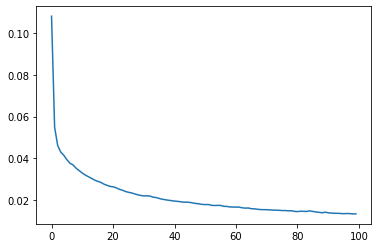

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [ ]:
Z = model.encoder(torch.tensor(X.astype(np.float32)).to(device))

In [ ]:
Z = Z.to('cpu').detach().numpy()

In [ ]:
# просто запуск DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import v_measure_score

clustering = DBSCAN().fit(Z)
print (np.unique(clustering.labels_))

print (f'V={v_measure_score(y, clustering.labels_)}')

[-1]
V=0.0


In [ ]:
import umap
reducer = umap.UMAP(n_neighbors=15, n_components=64, min_dist=0.1)
embedding = reducer.fit_transform(Z)

In [ ]:
clustering = DBSCAN().fit(embedding)
print (np.unique(clustering.labels_))

print (f'V={v_measure_score(y, clustering.labels_)}')

[-1  0  1  2  3  4  5  6  7  8  9 10]
V=0.050821089694211334


In [ ]:
# "умный перебор ??" НЕ РАБОТАЕТ!!!!

# %%
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import make_scorer

def score_func(y_true, y_pred, **kwargs):
    return v_measure_score(y_true, y_pred)
scorer = make_scorer(score_func)


from sklearn.model_selection import GridSearchCV


base_opt = DBSCAN()
grid_search_params = {"min_samples":np.arange(10),
                        "eps":[0.001, 0.01, 0.05, 0.1, 0.2]}

grid_search_cv = GridSearchCV(estimator=base_opt,
                                param_grid=grid_search_params,
                                scoring=scorer)

grid_search_cv.fit(X, y)

GridSearchCV(estimator=DBSCAN(),
             param_grid={'eps': [0.001, 0.01, 0.05, 0.1, 0.2],
                         'min_samples': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring=make_scorer(score_func))

In [ ]:
grid_search_cv.cv_results_

{'mean_fit_time': array([0.8972559 , 0.94811902, 0.75881109, 0.61549244, 0.617523  ,
        0.61192832, 0.61926355, 0.61944776, 0.6121037 , 0.60665574,
        0.61789083, 0.63896122, 0.61545715, 0.62140393, 0.62202125,
        0.60895128, 0.61401548, 0.61523528, 0.71359167, 0.60869546,
        0.61945233, 0.63438616, 0.60807204, 0.60719352, 0.61616864,
        0.61635227, 0.61535869, 0.61093593, 0.60999212, 0.61265845,
        0.6197576 , 0.77686715, 0.60534415, 0.61044016, 0.60401821,
        0.60203066, 0.60233264, 0.60543265, 0.5943233 , 0.60627627,
        0.61365867, 0.61656098, 0.58812757, 0.59287815, 0.57725143,
        0.57703819, 0.58473983, 0.57458615, 0.76577506, 0.56030059]),
 'mean_score_time': array([0.00041504, 0.00031843, 0.00024424, 0.00021892, 0.00022063,
        0.00022883, 0.00025711, 0.00022702, 0.00028086, 0.00021005,
        0.00023599, 0.00026927, 0.00022335, 0.00026836, 0.0002388 ,
        0.00021949, 0.00021882, 0.00022535, 0.0002564 , 0.00022316,
        0.

In [ ]:
a = [(lambda: i for i in range(3))]
b = [f() for f in a]
print (b)

TypeError: ignored

In [ ]:
print(lambda: 1, lambda: 2, lambda: 3)

<function <lambda> at 0x7f4abb9d8a70> <function <lambda> at 0x7f4abb9d8b00> <function <lambda> at 0x7f4abb9d8b90>


In [ ]:
a = [(lambda: 1), (lambda: 2)]
a

[<function __main__.<lambda>()>, <function __main__.<lambda>()>]

In [ ]:
a = [(lambda: 1), (lambda: 2)]

In [ ]:
b = [f() for f in a]
print (b)

[1, 2]


In [ ]:
a = []
for i in range(3):
    def fun(): return i
    a.append(fun)
b = [f() for f in a]
print (b)

[2, 2, 2]


In [ ]:
[id(s) for s in a]

[139958952197152, 139958952195280, 139958952196720]

In [ ]:
print (id(lambda: 1) == id(lambda: 2))

True


In [ ]:
a = []
for i in range(3):
    def fun(): return i
    a.append(fun)
b = [f() for f in a]
print ([id(s) for s in b])

[11256096, 11256096, 11256096]


In [ ]:
a = []
for i in range(3):
    if i == 0:
        def foo(): return i
        a.append(foo)
    else:
        def bar(): return i
        a.append(bar)

In [ ]:
b = [f() for f in a]
print (b)

[2, 2, 2]


In [ ]:
id(lambda: 1) == id(lambda: 2)

True